## **1 Project Title: House price Prediction**

## **2 Algorithms: Lasso, RandomFarest, XGBoost, and a detailed EDA**

## <font color='#FF9FD6'>**3 Loading libraries required and reading the data**</font>


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.linear_model as linear_model
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import  johnsonsu , zscore, skew, boxcox_normmax  # for some statistics
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, Lasso
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Assign identifiers
train['train_test'] = 1  
test['train_test'] = 0  

# Assign NaN to test SalePrice
test['SalePrice'] = np.nan   # Assign NaN to missing target variable in the test set

In [3]:
print(f'train_shape', train.shape, 'test_shape', test.shape)   

train_shape (1460, 82) test_shape (1459, 82)


In [ ]:
#drop the last record of train data to have the same records on both dataset
train.drop(index=1459, inplace=True)
print(f'train_shape', train.shape, 'test_shape', test.shape)   

train_shape (1459, 82) test_shape (1459, 82)


In [6]:
#Both datasets concatenated into a single dataframe for `consistent preprocessing`.
# Concatenate datasets
df = pd.concat([train, test], axis=0, ignore_index=True)  

# Check if concatenation was successful
print(df['train_test'].value_counts())  


# Filter test set
df_train = df[df['train_test'] == 1]
df_test = df[df['train_test'] == 0]

train_test
1    1459
0    1459
Name: count, dtype: int64


## <font color='#FF9FD6'>**4 Data Cleaning**</font>

In [7]:
#drop Id column for whole dataset
df.drop(columns=['Id'], inplace=True)
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    Inside  ...    NaN   NaN         NaN       0   
1         Lvl    AllPub       FR2  ...    NaN   NaN         NaN       0   
2         Lvl    AllPub    Inside  ...    NaN   NaN         NaN       0   
3         Lvl    AllPub    Corner  ...    NaN   NaN         NaN       0   
4         Lvl    AllPub       FR2  ...    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  train_test  
0      2   2008        WD         Normal   208500.0           1  
1      5   2007        WD         Normal   181500.0           1  
2      9   2008        WD         Normal   223500.0           1  
3      2   2006        WD        Abnorml   140000.0           1  
4     12   2008        WD         Normal   250000.0           1  

[5 rows x 81 columns]

### <font color='#7FFFD4'>**4.1 Handling Duplicate**</font>

In [8]:
#Chech for duplicates
duplicates = df.duplicated(keep=False)
all_duplicate= df[duplicates]
all_duplicate

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, train_test]
Index: []

[0 rows x 81 columns]

`There is no duplicate data`

### <font color='#7FFFD4'>**4.2 Handling missing values**</font>

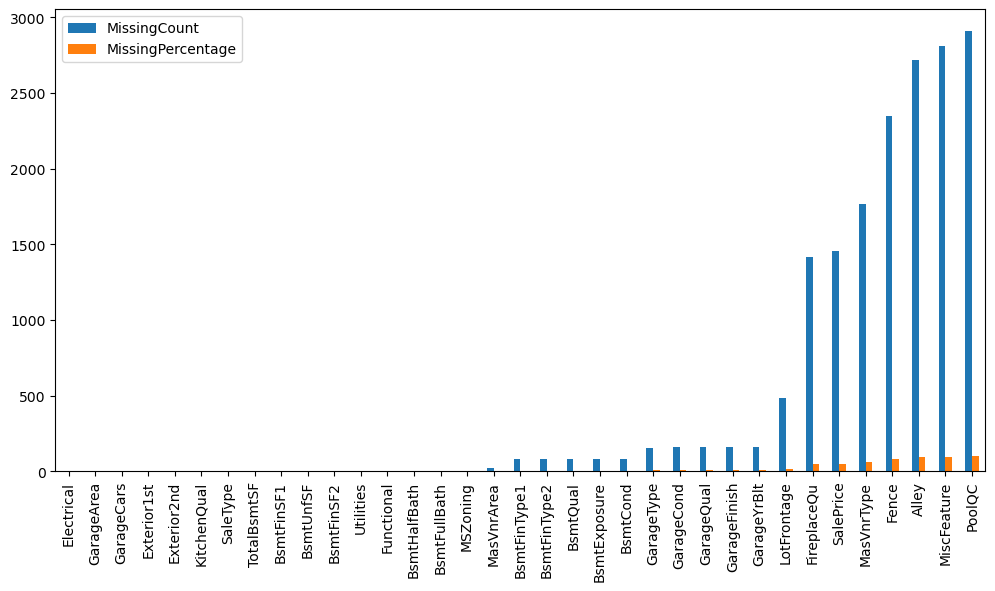

In [9]:
#Visualize missing values in the whole data
# Checking for missing values in the combined dataset
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['MissingCount', 'MissingPercentage']

sns.set_style()
missing=missing[missing['MissingCount'] > 0]
missing.sort_values(by='MissingCount',inplace=True)
missing.plot(kind='bar', figsize=(12,6))
plt.show()

#### **Insights from missing data**
- According to the bar chart: 35 features have missing values, 6 features are 50% and above, 23 features are below 5% and 6 features are between (5-20)%.
- Missing data was computed according to median and mode methods.
- To fix the 35 predictors that contains missing values. When I go through each feature having NAs there are multiple variables that relate to Pool, Garage, and Basement, so I deal with them as a group referring to meta data which shows definiton of variables and make it clear that NA in that feature doesn't mean missed value, it means that house dosn't have Pool, Garage, or Basement, so it will be replaced with NONE.
- listing features having NAs values
    - Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC and Fence.

In [10]:
# Checking for missing values in the combined dataset
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['MissingCount', 'MissingPercentage']
missing.sort_values(by='MissingCount',inplace=True)
pd.set_option('display.max_rows', None)  # This will show all rows
#pd.reset_option('display.max_rows')  # Resets to default display behavior
missing

MissingCount  MissingPercentage
MSSubClass                0           0.000000
Heating                   0           0.000000
HeatingQC                 0           0.000000
1stFlrSF                  0           0.000000
2ndFlrSF                  0           0.000000
LowQualFinSF              0           0.000000
GrLivArea                 0           0.000000
FullBath                  0           0.000000
HalfBath                  0           0.000000
BedroomAbvGr              0           0.000000
KitchenAbvGr              0           0.000000
TotRmsAbvGrd              0           0.000000
Fireplaces                0           0.000000
PavedDrive                0           0.000000
WoodDeckSF                0           0.000000
OpenPorchSF               0           0.000000
EnclosedPorch             0           0.000000
3SsnPorch                 0           0.000000
ScreenPorch               0           0.000000
PoolArea                  0           0.000000
MiscVal                   0           0.000000
MoSold                    0           0.000000
YrSold                    0           0.000000
SaleCondition             0           0.000000
Foundation                0           0.000000
ExterCond                 0           0.000000
CentralAir                0           0.000000
Condition2                0           0.000000
LotArea                   0           0.000000
Street                    0           0.000000
LotShape                  0           0.000000
LandContour               0           0.000000
LotConfig                 0           0.000000
LandSlope                 0           0.000000
Neighborhood              0           0.000000
Condition1                0           0.000000
ExterQual                 0           0.000000
BldgType                  0           0.000000
HouseStyle                0           0.000000
OverallQual               0           0.000000
OverallCond               0           0.000000
YearBuilt                 0           0.000000
YearRemodAdd              0           0.000000
train_test                0           0.000000
RoofMatl                  0           0.000000
RoofStyle                 0           0.000000
BsmtFinSF1                1           0.034270
SaleType                  1           0.034270
BsmtFinSF2                1           0.034270
BsmtUnfSF                 1           0.034270
GarageCars                1           0.034270
KitchenQual               1           0.034270
Exterior2nd               1           0.034270
Exterior1st               1           0.034270
Electrical                1           0.034270
TotalBsmtSF               1           0.034270
GarageArea                1           0.034270
Functional                2           0.068540
BsmtHalfBath              2           0.068540
Utilities                 2           0.068540
BsmtFullBath              2           0.068540
MSZoning                  4           0.137080
MasVnrArea               23           0.788211
BsmtFinType1             79           2.707334
BsmtFinType2             80           2.741604
BsmtQual                 81           2.775874
BsmtExposure             82           2.810144
BsmtCond                 82           2.810144
GarageType              157           5.380398
GarageCond              159           5.448938
GarageFinish            159           5.448938
GarageQual              159           5.448938
GarageYrBlt             159           5.448938
LotFrontage             486          16.655243
FireplaceQu            1419          48.629198
SalePrice              1459          50.000000
MasVnrType             1765          60.486635
Fence                  2347          80.431803
Alley                  2720          93.214531
MiscFeature            2813          96.401645
PoolQC                 2908          99.657300

In [11]:
# Categorical Features have NA filled with None, beacuse not having this feature has impact on house price
columns_to_fill_none = ['Alley','MasVnrType','BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'FireplaceQu','GarageType',
         'GarageFinish','GarageQual','GarageCond', 'PoolQC','Fence']
df[columns_to_fill_none] = df[columns_to_fill_none].fillna(value='None')


# Fill categorical missing values with mode for each specified column
columns_to_fill_with_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                             'Electrical', 'KitchenQual', 'Functional', 'SaleType']

# Fill missing values with the mode of each column
for column in columns_to_fill_with_mode:
    df[column].fillna(df[column].mode()[0], inplace=True)


# Numerical Features
# Fill numerical missing with median
numcolumns_to_fill_with_median = ['LotFrontage','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                                  'BsmtHalfBath','BsmtFullBath','GarageYrBlt','GarageCars','GarageArea','MasVnrArea']

# Fill missing values with the median of each column
for column in numcolumns_to_fill_with_median:
    df[column].fillna(df[column].median(), inplace=True)    

In [12]:
# MiscFeature feature is mix of 5 elements and NA, assigning None dosn't define which element, so it was droped
df.drop(columns=['MiscFeature'], inplace=True)
print(df.shape)

(2918, 80)


In [13]:
# Checking for missing values in the combined dataset after handling Missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['MissingCount', 'MissingPercentage']
missing.sort_values(by='MissingCount',inplace=True)
#pd.set_option('display.max_rows', None)  # This will show all rows
pd.reset_option('display.max_rows')  # Resets to default display behavior
missing

MissingCount  MissingPercentage
MSSubClass              0                0.0
GarageType              0                0.0
FireplaceQu             0                0.0
Fireplaces              0                0.0
Functional              0                0.0
...                   ...                ...
Exterior2nd             0                0.0
Exterior1st             0                0.0
RoofMatl                0                0.0
train_test              0                0.0
SalePrice            1459               50.0

[80 rows x 2 columns]

`Except SalePrice for test set, there is not any missing value.`

## <font color='#FF9FD6'>**5 Exploring Data Analysis (EDA) and Data Wrangling**</font>

In [14]:
#To establish different visualization on numerical and categorical features, I Checked for the numerical and categorical features and split them
numerical = [feature for feature in df.columns if df.dtypes[feature] != 'object']
numerical.remove('SalePrice')
categorical = [feature for feature in df.columns if df.dtypes[feature] == 'object']
numerical_data = df[numerical]
numerical_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'train_test'],
      dtype='object')

In [15]:
categorical_data = df[categorical]
categorical_data.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

### <font color='#7FFFD4'>**5.1 Visualization**</font>

In [16]:
# Numerical and categorical feature 
original_numfeatures = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']

original_catfeatures = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition']

In [17]:
# Split back into train and test sets to do EDA and visualization on train setdata
train_cleaned = df[df.train_test == 1].drop(['train_test'], axis=1)
test_cleaned = df[df.train_test == 0].drop(['train_test'], axis=1)

print(f"Train cleaned data size: {train_cleaned.shape[0]}")
print(f"Test cleaned data size: {test_cleaned.shape[0]}")


Train cleaned data size: 1459
Test cleaned data size: 1459


In [18]:
train_cleaned.isnull().sum().any()

False

In [19]:
test_cleaned.isnull().sum().any()

True

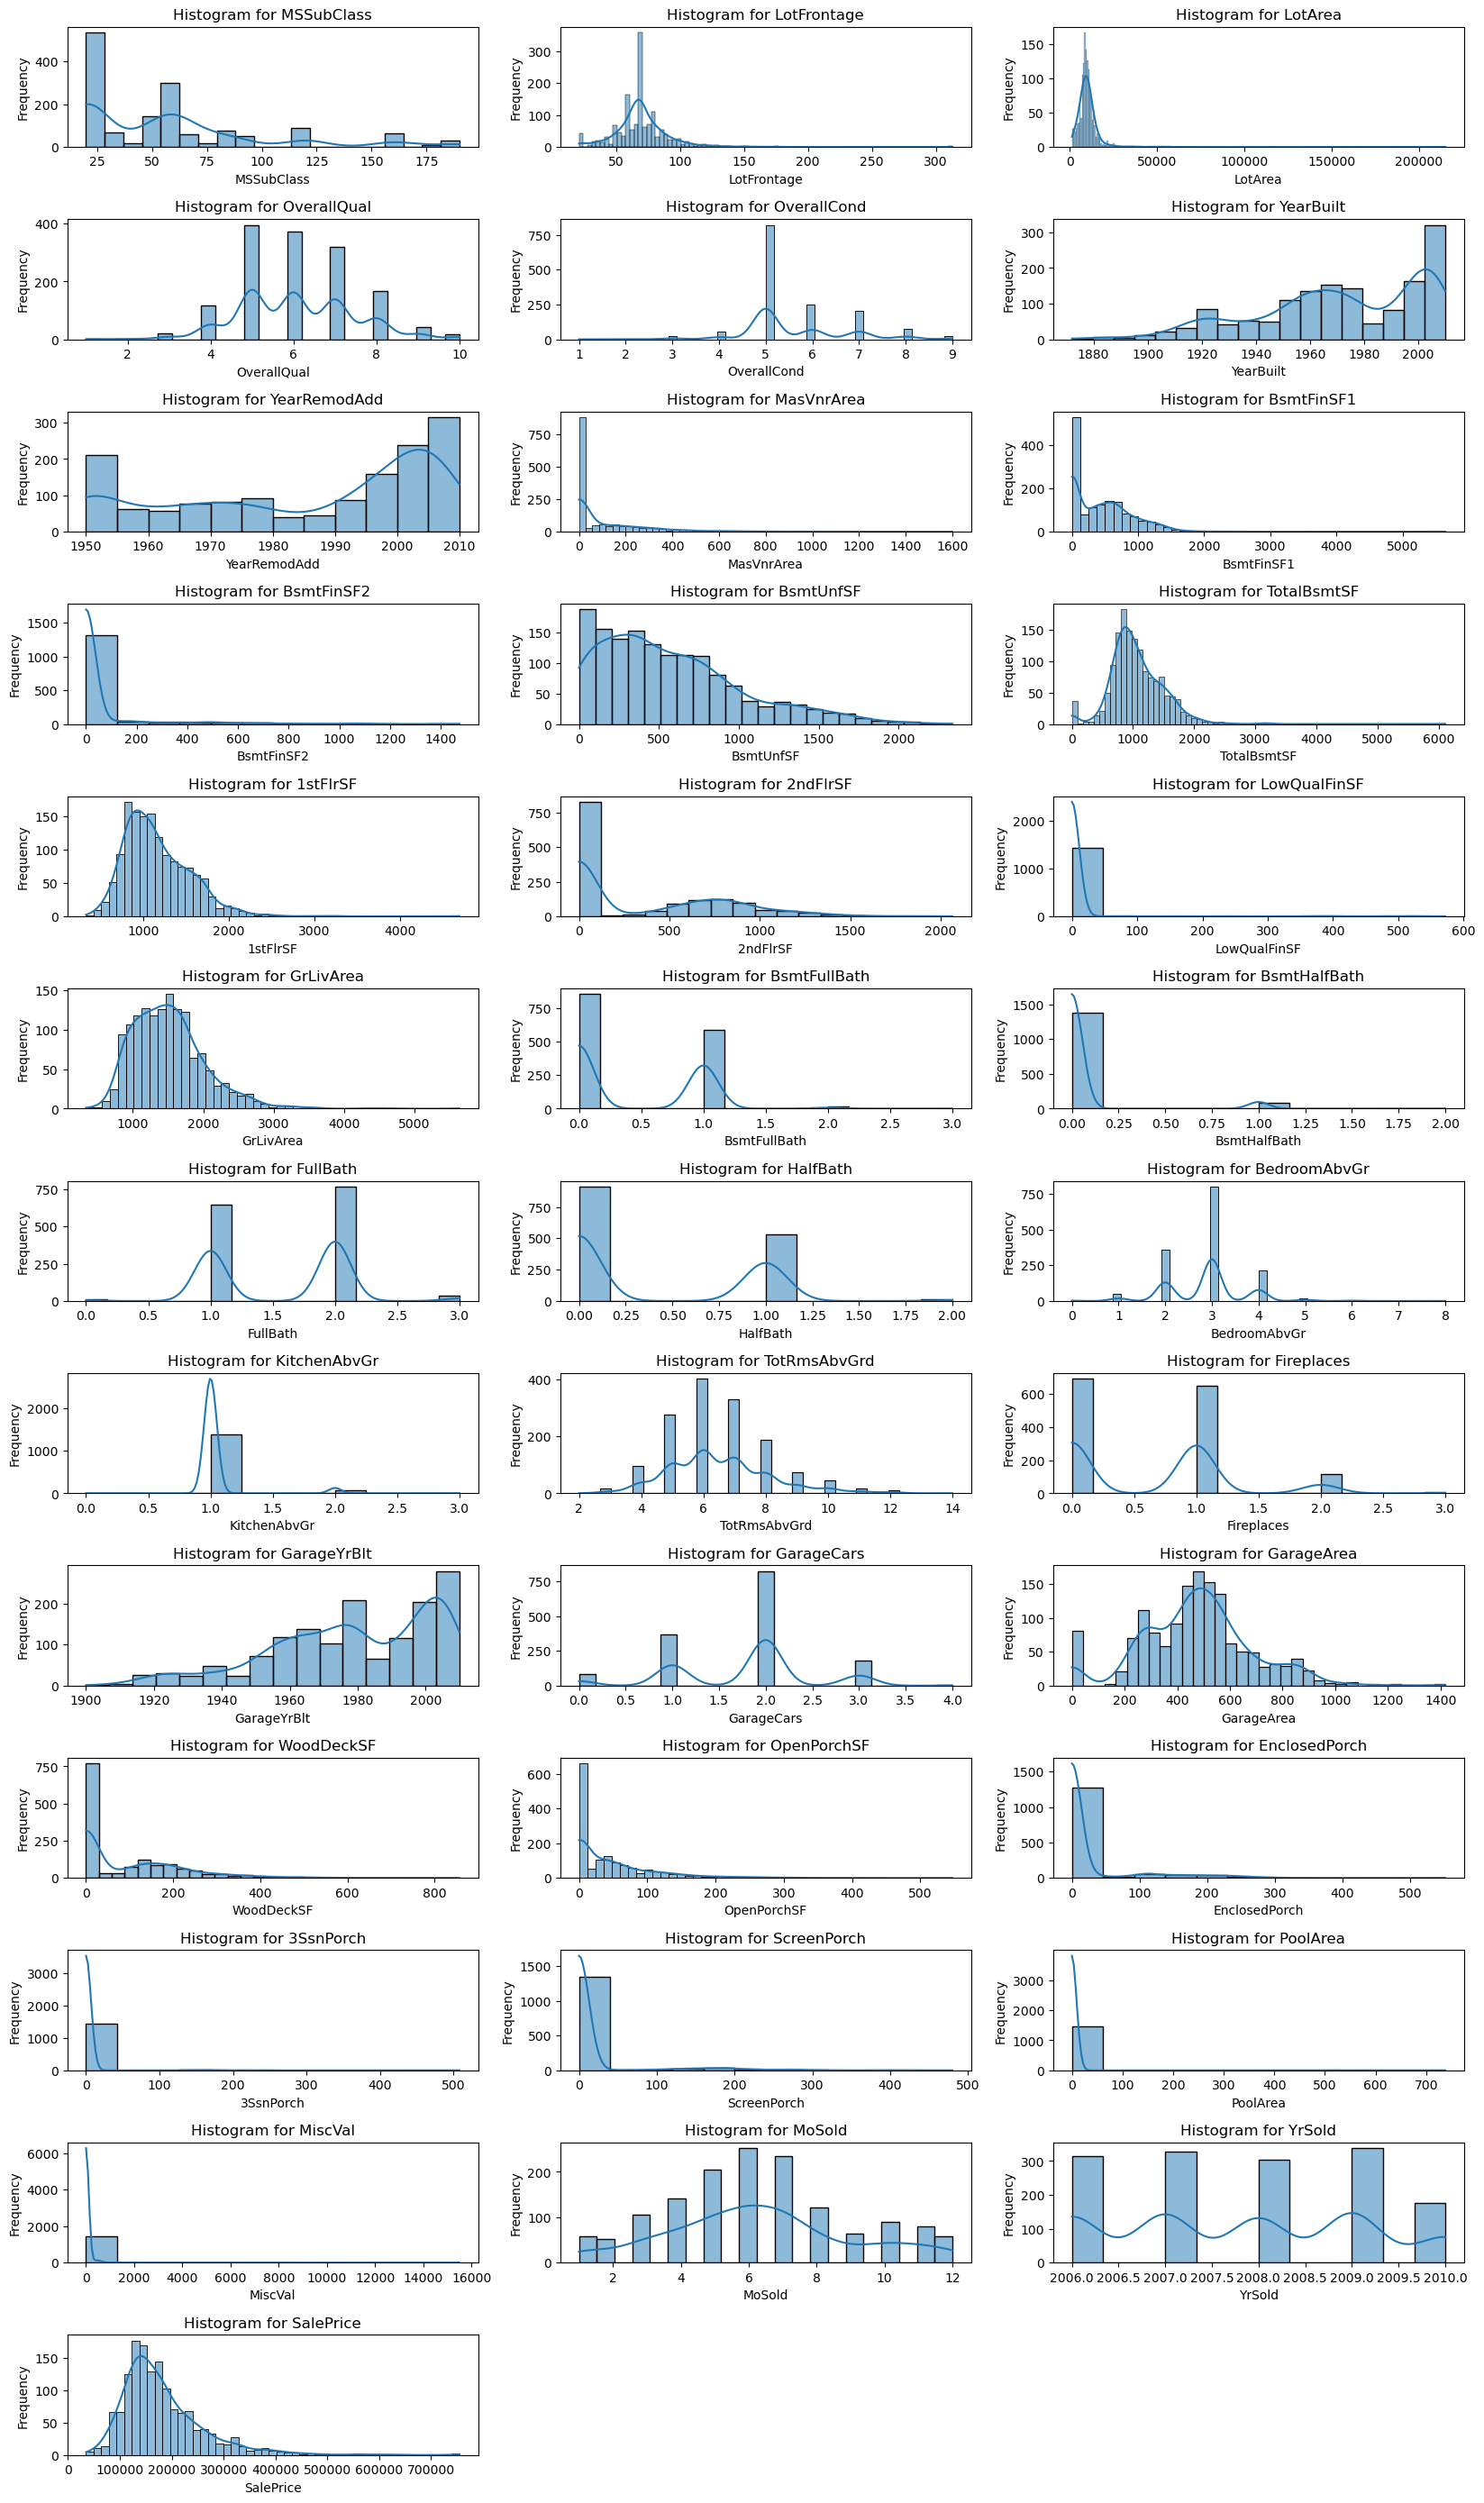

In [ ]:
#Histplot to dive into features
plt.figure(figsize=(20, 35))  # Increase figure size
numcolumns =  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'] 
for i, column in enumerate(numcolumns, 1):
    plt.subplot(13, 3, i)  # Adjust the grid for better layout
    sns.histplot(train_cleaned[column], kde=True)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Add more spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.2)

plt.show()

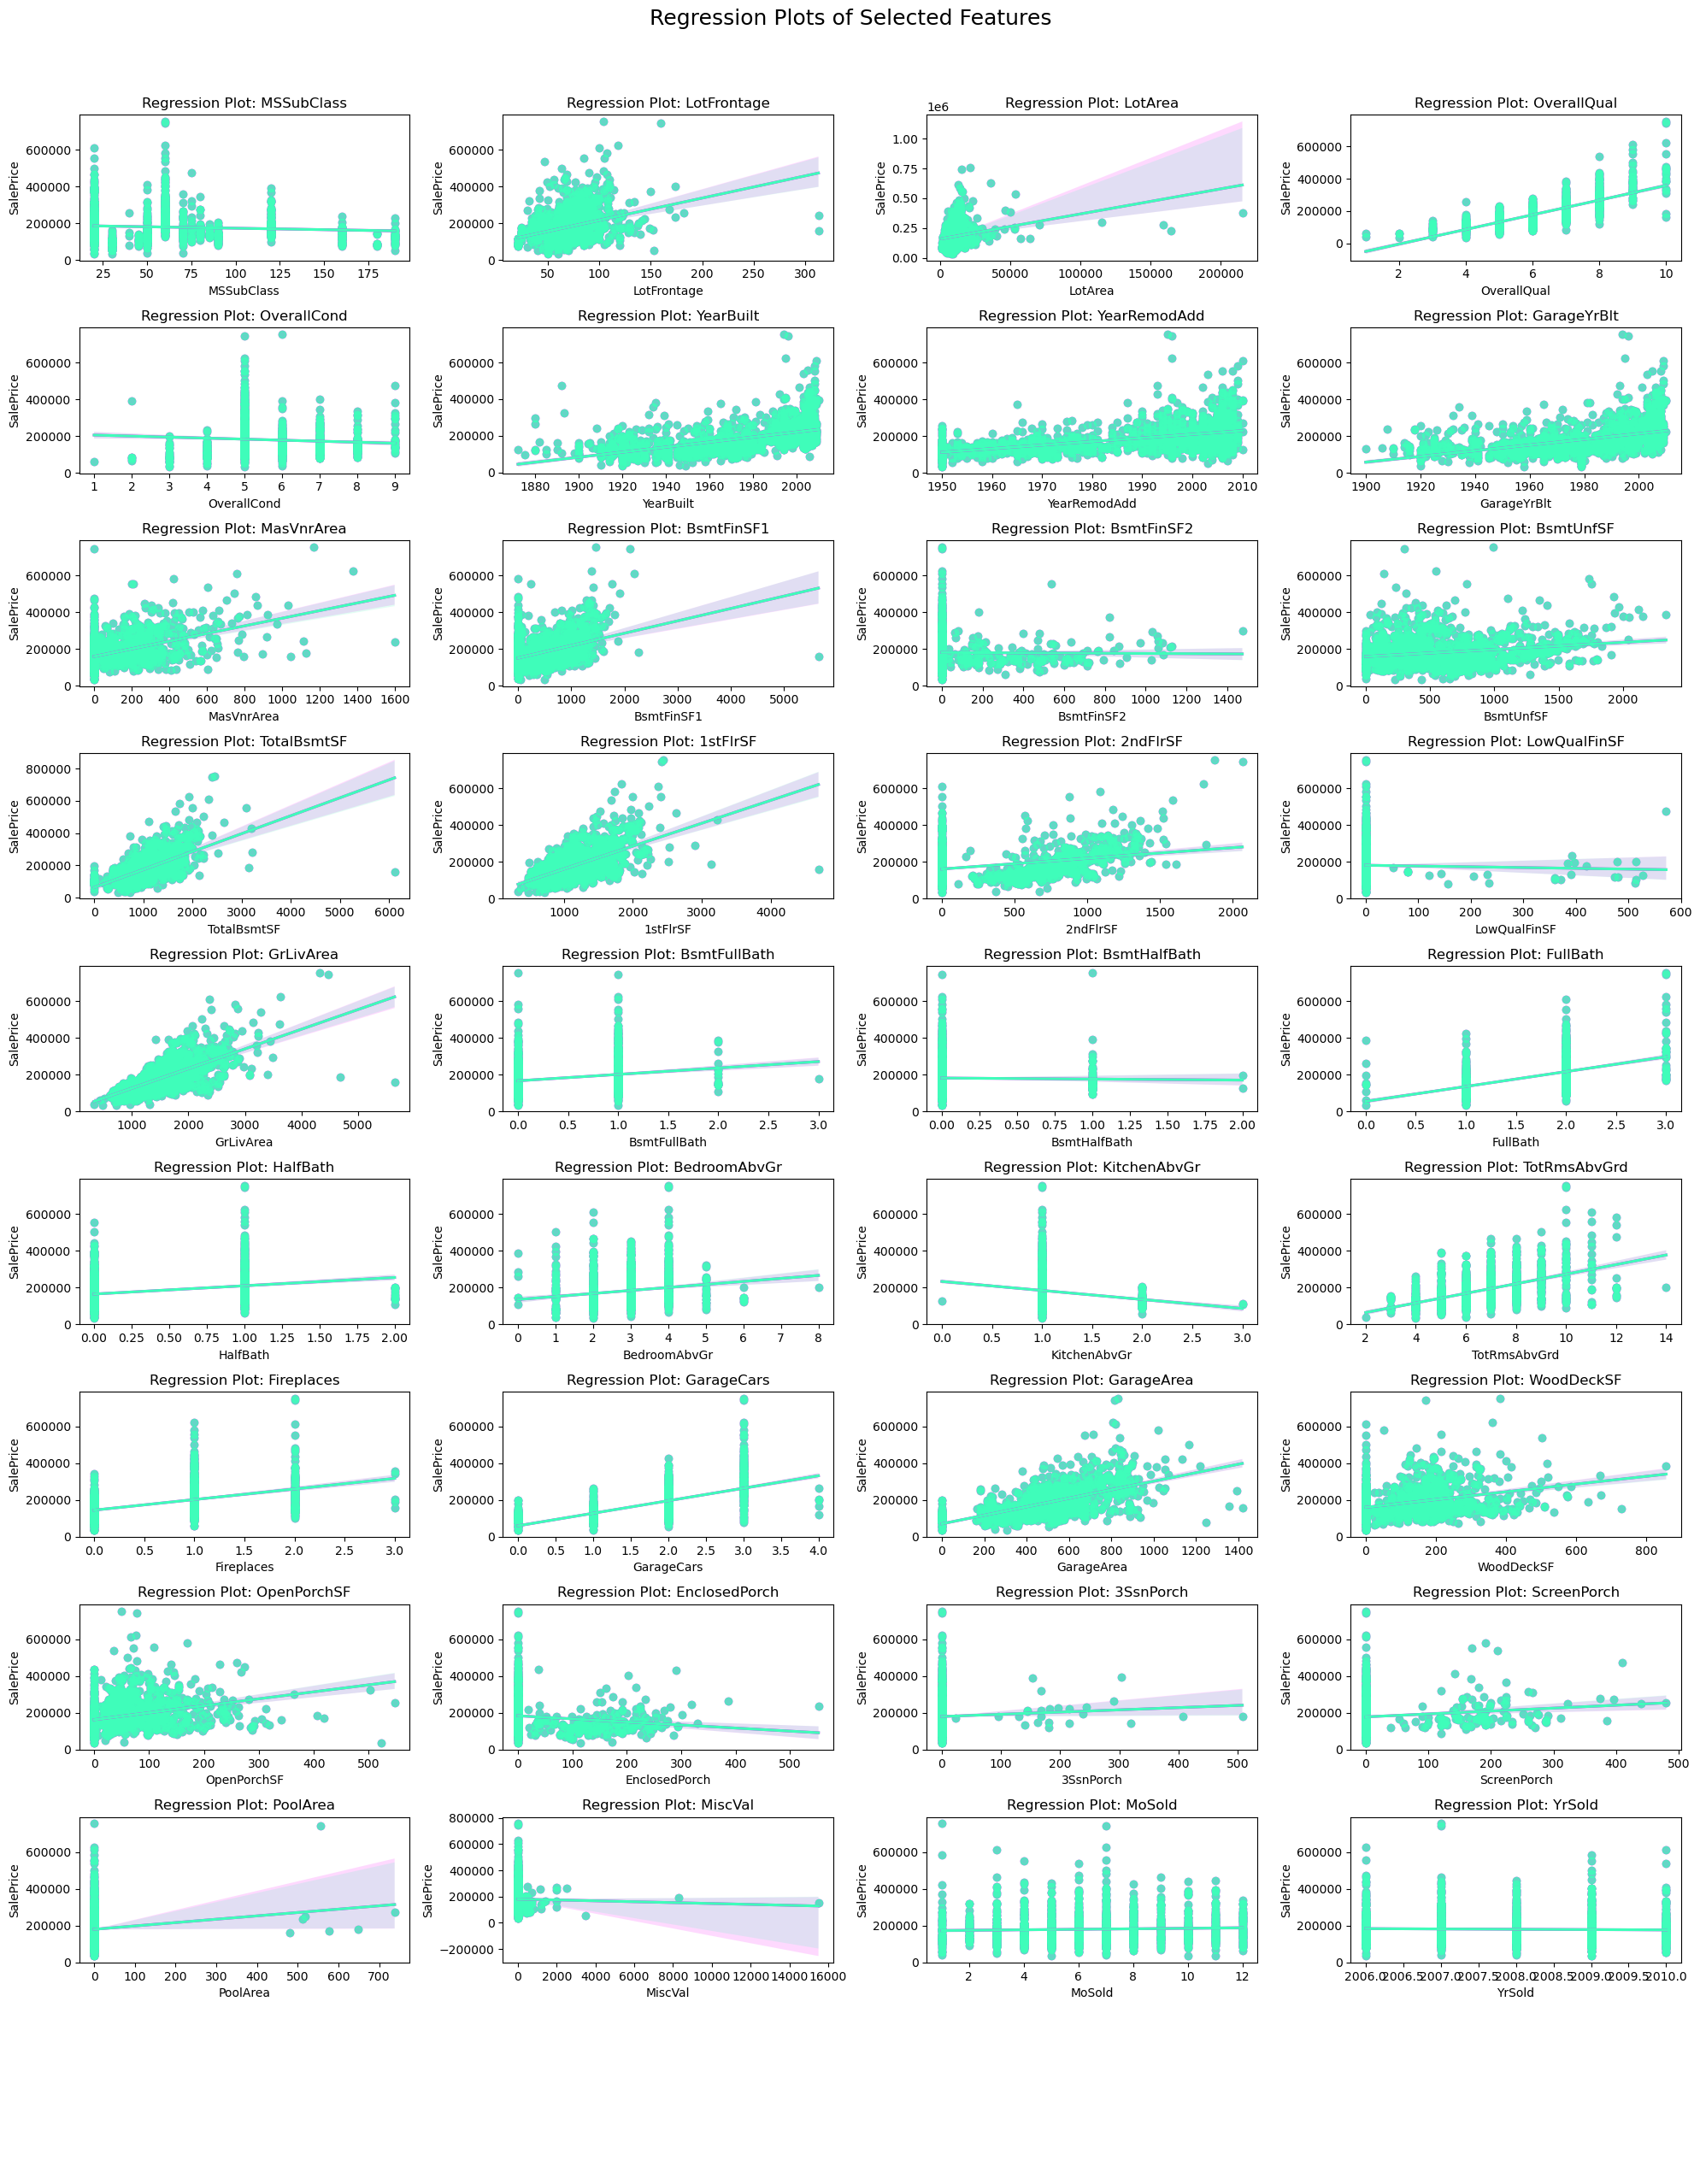

In [21]:
#develpe Regression plot 
fig, axes = plt.subplots(10, 4, figsize=(20, 25))  # Adjusting grid to fit 36 numerical features
axes = axes.flatten()  # Flattening for easier iteration

mypal = ['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA']

numerical_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'GarageYrBlt','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'] 

# Loop through each feature and plot regression
for i, col in enumerate(numerical_features):
    if i < len(axes):  # Ensure no index out of bounds
        sns.regplot(data=train_cleaned, x=col, y='SalePrice', ax=axes[i], 
                    color=mypal[0], label='SalePrice=1')
        sns.regplot(data=train_cleaned, x=col, y='SalePrice', ax=axes[i], color=mypal[5])

        axes[i].set_title(f'Regression Plot: {col}')
        
# Hiding unused subplots
for i in range(len(numerical_features), len(axes)):
     axes[i].axis('off')

# Overall title
plt.suptitle('Regression Plots of Selected Features', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## <font color='#FF6347'>**Note resulted form Scatter-regression plots:**</font>

- Features show `no relation` with Price;
   - MSSubClass, LowQualFinSF, BmtFinSF2, BsmtHalfBath, 3SsnPorch, MiscVal, MoSold, YrSold, ScreenPorch,

- Features with `positive relation with price, high slop regression line`considered as highly important features;
   - GrLivArea (Above grade living area), OveralQual, totalBsmtSF(Total square feet of basement area),TotRmsAbvGrd, 1stFlrSF(First Floor square feet), BsmtFinishSF1, LotFrontAge,LotArea, MasVnrArea
   - the recent year the higher price, `YearBuilt`, `YearRemodAdd`, `GarageYrBlt`

- Features with `positive relation, gentel slop regression line`considered as importance features;
   -  BsmtFullBath, FullBath(Full bathrooms above grade), HalfBath, BedroomAbvGr, FirePlace, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, 2ndFlrSF, BsmtUnfSF, PoolArea

- If year related features be converted to Age, so these Features will present `negative relation, gentel slop regression line`considered as importance features; 
   - Age_housBlt, Age_RemodAdd, Age_GargeBlt , KitchenAbvGr, EnclosedPorch 

- Regarding outliers, except two data points, extreme values are not seen. If there is a candidate to take out as an outlier later on, it seems to be the expensive house. It is seen two data points on Lotfrontage, and GrLivArea.

- It also becomes clear the `multicollinearity` is an issue. For example:
   - GarageCars and GarageArea show the same correlations with SalePrice and high correlation between them (0.89).
   - Age_houseBlt, Age_RemodAdd, Age_GargeBlt show the same issue.

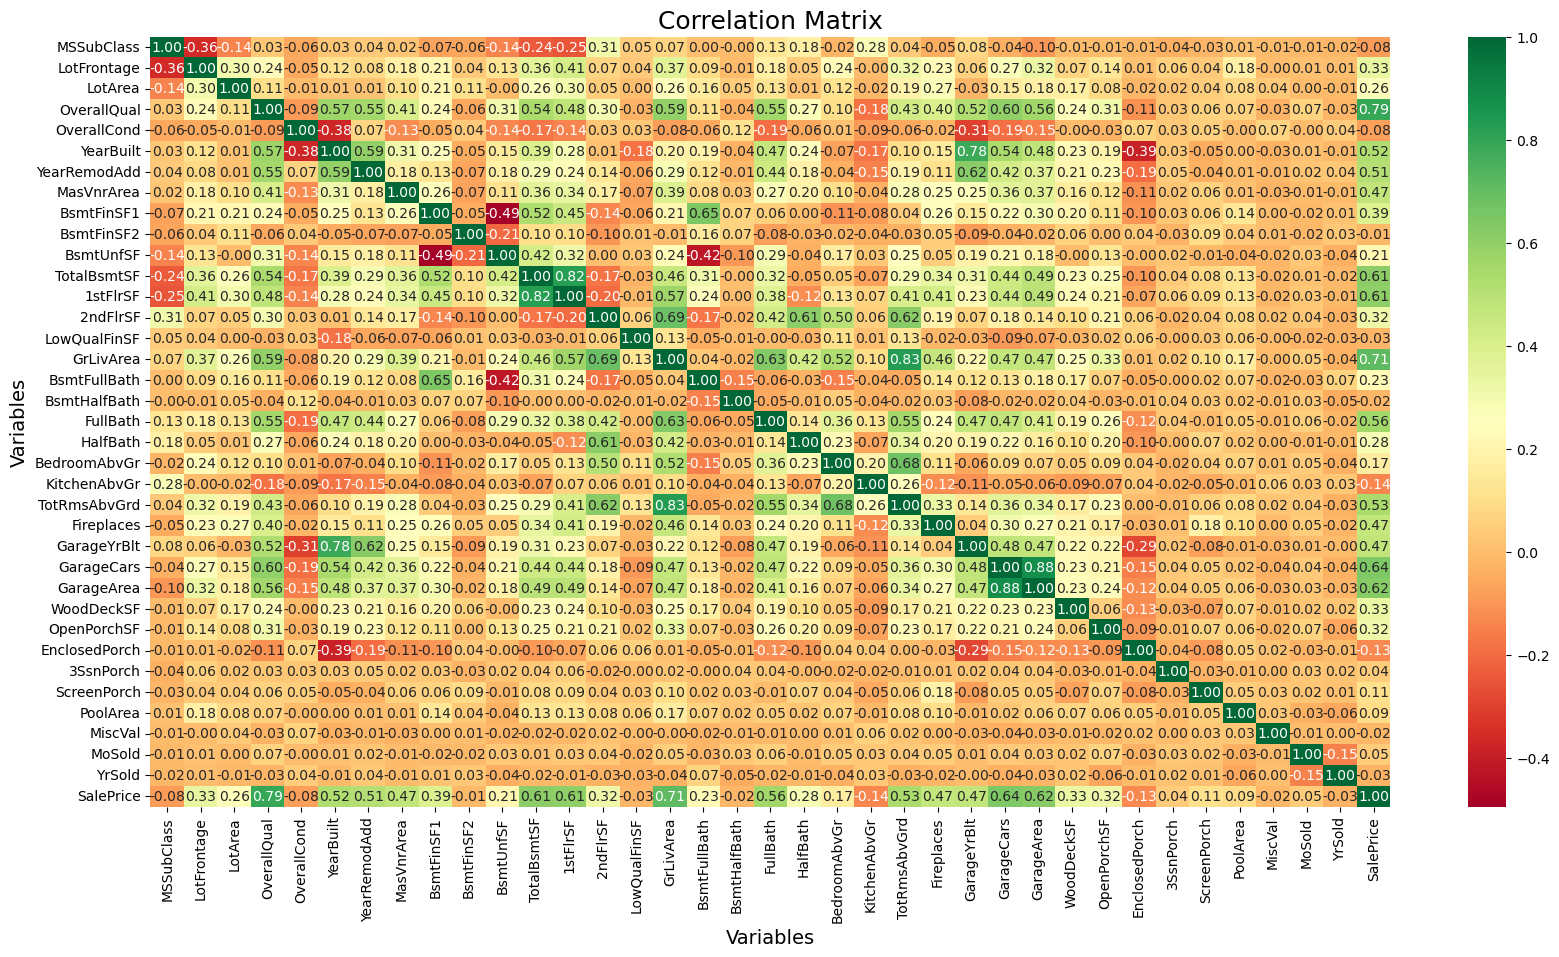

In [22]:
#Corrolation map with Pearson method
train_corr = train_cleaned
plt.figure(figsize=(20,10))
numeric_df = train_corr.select_dtypes(include=['float', 'int'])
corr= numeric_df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True , fmt='.2f')

plt.title('Correlation Matrix', fontsize=18)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)

plt.show()

## Insights from Feature Relationships Based on Correlation Graphs
- Strong Positive Correlations:
  - Features like  `OveralQual (0.79)`, `GrLivArea(0.71)`, `Garagcars(0.64)`, `GaragArea(0.62)`,
   `TotRmsAbGrd(0.53)`, `FullBath(0.56)`, `TotalBsmtSF(0.61)`, `1stFlrSF(0.61)`, `YearRemodAdd(0.51)`,
    `YearBuilt(0.52)`  with high positive correlations to SalePrice are critical in predicting house prices. 
- Strong Negative Correlations:
  - There is no feature in this chart shows strong negative correlation. However, if I do feature engineering
   on year related features to **`Age`** may I see this type of correlation as Age of house increases, the house price tends to decrease.
- Weak or No Correlations (result between 0.45- -0.14):
Rest of the Features show weak or no correlation to SalePrice and may not contribute meaningfully to the price prediction. 
these features might not show strong correlations with price and could be less influential in price modeling.
  - Features are MSSubClass, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, BsmtFinType1, BsmtFinSF1, BsmtFinType2, WoodDeckSF, OpenPorchSF,
   LotArea, OverallCond, BsmtFinSF2, BedroomAbvGr, 3SsnPorch, PoolArea, 2ndFlrSF, MiscVal, HalfBath, ScreenPorch, MoSold, YrSold, MoSold,
    LotFrontage, MasVnrArea, KitchenAbvGr, EnclosedPorch, LowQualFinSF 

## Based on the outcomes of the correlation chart above the new correlation chart was constructed
- several features show a strong relationship with the target variable (SalePrice). The features with correlation values ranging from 0.79 to 0.47 indicate a moderate to strong positive correlation. These relationships highlight the most impactful features for predicting house prices, as identified in the correlation chart below.

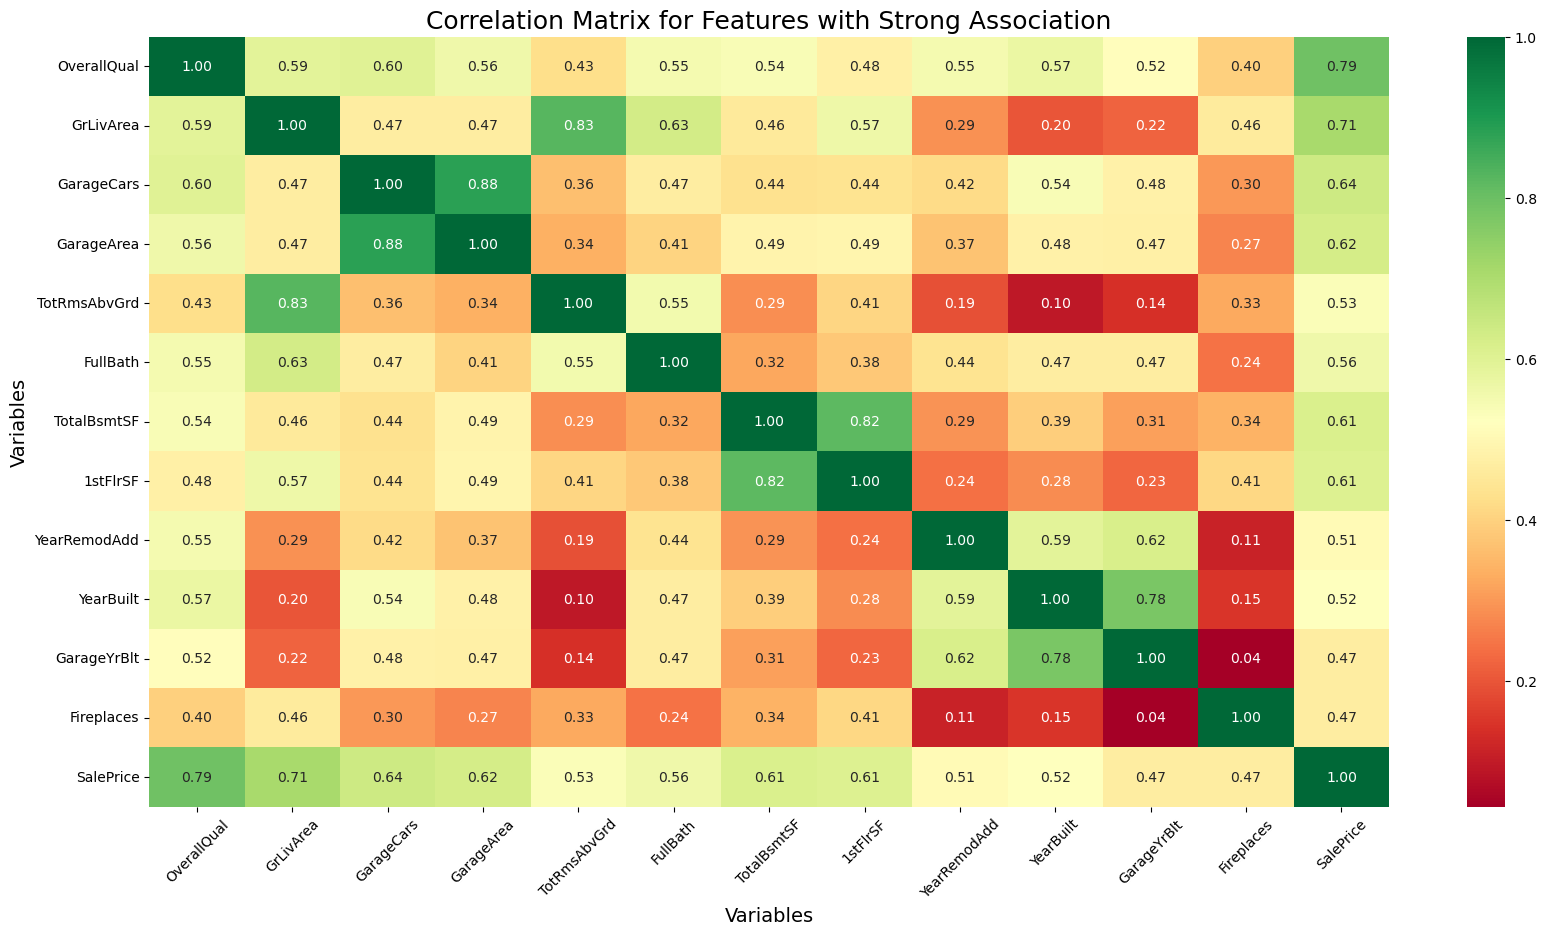

In [23]:
# After reviweing heat map above with all the numerical features and finding strenght relationship among features with SalePrice,
# the amount of 0.5 and over, the new heat map with picked features was prepared.
feature_with_strong_Asso = [ 'OverallQual','GrLivArea',  'GarageCars','GarageArea', 'TotRmsAbvGrd','FullBath', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd','YearBuilt','GarageYrBlt', 'Fireplaces', 'SalePrice']
#Corrolation map with Pearson method
train_corr = train_cleaned[feature_with_strong_Asso]
plt.figure(figsize=(20,10))
numeric_df = train_corr.select_dtypes(include=['float', 'int'])
corr= numeric_df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True , fmt='.2f')

plt.title('Correlation Matrix for Features with Strong Association', fontsize=18)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)

plt.show()

### **Insights of Corrolation Map**
- According to corrolation map and the relationship between numerical features and target variable, the strenght relation of features from the range of 0.79 to 0.47 are respectivly:
    - 1- OverallQuall with 0.79 has the highest positive relation.
    - 2- GrLivArea with 0.71 has the second high relation.
    - 3- Garage car and garageArea have the close same amonut of 0.64 and 0.62 respectively. This could lead to Multicollinearity.
    - 4- TotalBasmSF and 1stFlrSF show 0.61.
    - 4- FullBath shows 0.56 positive relation.
    - 5- TotRmsAbvGrd shows 0.51
    - 6- YearBulit and YearRemodAdd have 0.52.
    - 7- GarageYrBlt, and FirePlace show 0.47.

### <font color='#7FFFD4'>**5.2 Feature Engineering**</font>
- #### refering to histogram plot, features with no relationship that could be vonvert to categorical feature, as weel as in order to make the dataset more meaningful and well-structured for EDA, I replaced the numerical encoded values of features  MSSubClass and MoSold to their Real State terms.

In [24]:
#In order to make the dataset more meaningful and well-structured for EDA, I replaced the numerical encoded values of features  MSSubClass, MoSold to their Real State terms. 
df['MSSubClass'][df['MSSubClass'] == 20] = 'one_StoNew'
df['MSSubClass'][df['MSSubClass'] == 30] = 'one_StoOld'
df['MSSubClass'][df['MSSubClass'] == 40] = 'one_StoFin'
df['MSSubClass'][df['MSSubClass'] == 45] = 'one_onehalfStoUnFin'
df['MSSubClass'][df['MSSubClass'] == 50] = 'one_onehalfStoFin'
df['MSSubClass'][df['MSSubClass'] == 60] = 'two_StoNew'
df['MSSubClass'][df['MSSubClass'] == 70] = 'two_StoOld'
df['MSSubClass'][df['MSSubClass'] == 75] = 'two_onehalfSto'
df['MSSubClass'][df['MSSubClass'] == 80] = 'Split'
df['MSSubClass'][df['MSSubClass'] == 85] = 'SplitFoy'
df['MSSubClass'][df['MSSubClass'] == 90] = 'Duplex'
df['MSSubClass'][df['MSSubClass'] == 120] = 'one_StoPUD'
df['MSSubClass'][df['MSSubClass'] == 150] = 'one_onehalfStoPUD'
df['MSSubClass'][df['MSSubClass'] == 160] = 'two_StoPUD'
df['MSSubClass'][df['MSSubClass'] == 180] = 'PUD'
df['MSSubClass'][df['MSSubClass'] == 190] = 'two_twoFamiConv'


df['MoSold'][df['MoSold'] == 1] = 'January'
df['MoSold'][df['MoSold'] == 2] = 'February'
df['MoSold'][df['MoSold'] == 3] = 'March' 
df['MoSold'][df['MoSold'] == 4] = 'April'
df['MoSold'][df['MoSold'] == 5] = 'May'
df['MoSold'][df['MoSold'] == 6] = 'June'
df['MoSold'][df['MoSold'] == 7] = 'July'
df['MoSold'][df['MoSold'] == 8] = 'August'
df['MoSold'][df['MoSold'] == 9] = 'September'
df['MoSold'][df['MoSold'] == 10] = 'October'
df['MoSold'][df['MoSold'] == 11] = 'November'
df['MoSold'][df['MoSold'] == 12] = 'December'

In [25]:
# Feature Engineering: Create new features
df['Age_HouseBlt'] = df['YrSold'] - df['YearBuilt']  # Age of house
df['Age_RemodAdd'] = df['YrSold'] - df['YearRemodAdd'] # Since in the real state market, they talk about age of house, I figured out to Convert year to age.
df['Age_GarageBlt'] = df['YrSold'] - df['GarageYrBlt']  # List of year-based features and their corresponding age column names
df['TotalBath'] = df['FullBath'] + df['HalfBath'] * 0.5  # Total bath
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']  # Total porch area
df['TotalBsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5  # Total Basementbath
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']  # Total square feet
df['TotBsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalBsmtFinSF'] = df['TotBsmtFinSF']/(df['TotBsmtFinSF'] + df['BsmtUnfSF']+ 1)
df['Has_Pool'] = (df['PoolArea'] > 0).astype(int)  # Binary feature if the house has a pool
df['Has_Fireplace'] = (df['Fireplaces'] > 0).astype(int)  # Binary feature if the house has a fireplace

In [26]:
# Map ordinal categories to numerical values (assumed mapping)
fin_type_map = {
    'GLQ': 6,  # Good Living Quarters
    'ALQ': 5,  # Average Living Quarters
    'BLQ': 4,  # Below Average Living Quarters
    'Rec': 3,  # Average Rec Room
    'LwQ': 2,  # Low Quality
    'Unf': 1,  # Unfinished
    'None': 0  # No basement
}

df['BsmtFinType1_Score'] = df['BsmtFinType1'].map(fin_type_map)
df['BsmtFinType2_Score'] = df['BsmtFinType2'].map(fin_type_map)

# Weighted basement finish score based on area
df['WeightedBsmtFinScore'] = (
    df['BsmtFinSF1'] * df['BsmtFinType1_Score'] + df['BsmtFinSF2'] * df['BsmtFinType2_Score']
) / (df['TotBsmtFinSF'] + 1)  # Avoid division by zero

df['BsmtQualityScore'] = df['WeightedBsmtFinScore'] * df['TotBsmtFinSF']

In [27]:
# drop the year features 
df.drop(columns=['YrSold','YearBuilt','YearRemodAdd', 'GarageYrBlt','FullBath', 'HalfBath','BsmtFullBath','BsmtHalfBath', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                  'TotalBsmtSF','1stFlrSF','2ndFlrSF','BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','TotBsmtFinSF','BsmtFinType1','BsmtFinType2',  'BsmtFinType1_Score','BsmtFinType2_Score','WeightedBsmtFinScore','Fireplaces', 'PoolArea'], inplace=True)
# Check the resulting DataFrame
df.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  two_StoNew       RL         65.0     8450   Pave  None      Reg   
1  one_StoNew       RL         80.0     9600   Pave  None      Reg   

  LandContour Utilities LotConfig  ... Age_RemodAdd Age_GarageBlt TotalBath  \
0         Lvl    AllPub    Inside  ...            5           5.0       2.5   
1         Lvl    AllPub       FR2  ...           31          31.0       2.0   

  TotalPorchSF TotalBsmtBath TotalSF  TotalBsmtFinSF  Has_Pool Has_Fireplace  \
0           61           1.0  2566.0        0.823804         0             0   
1            0           0.5  2524.0        0.774347         0             1   

  BsmtQualityScore  
0      4230.008487  
1      4885.005107  

[2 rows x 69 columns]

In [28]:
# Check the resulting DataFrame
df.tail(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2916    SplitFoy       RL         62.0    10441   Pave  None      Reg   
2917  two_StoNew       RL         74.0     9627   Pave  None      Reg   

     LandContour Utilities LotConfig  ... Age_RemodAdd Age_GarageBlt  \
2916         Lvl    AllPub    Inside  ...           14          27.0   
2917         Lvl    AllPub    Inside  ...           12          13.0   

     TotalBath TotalPorchSF TotalBsmtBath TotalSF  TotalBsmtFinSF  Has_Pool  \
2916       1.0           32           0.5  1882.0        0.369113         0   
2917       2.5           48           0.0  2996.0        0.760281         0   

     Has_Fireplace BsmtQualityScore  
2916             0      2016.017751  
2917             1      1514.002635  

[2 rows x 69 columns]

In [29]:
# Split back into train and test sets to continue EDA and visualization on train setdata after feature engineering
train_cleaned_feng = df[df.train_test == 1].drop(['train_test'], axis=1)
test_cleaned_feng = df[df.train_test == 0].drop(['train_test'], axis=1)

In [30]:
train_cleaned_feng.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  two_StoNew       RL         65.0     8450   Pave  None      Reg   
1  one_StoNew       RL         80.0     9600   Pave  None      Reg   

  LandContour Utilities LotConfig  ... Age_RemodAdd Age_GarageBlt TotalBath  \
0         Lvl    AllPub    Inside  ...            5           5.0       2.5   
1         Lvl    AllPub       FR2  ...           31          31.0       2.0   

  TotalPorchSF TotalBsmtBath TotalSF  TotalBsmtFinSF  Has_Pool Has_Fireplace  \
0           61           1.0  2566.0        0.823804         0             0   
1            0           0.5  2524.0        0.774347         0             1   

  BsmtQualityScore  
0      4230.008487  
1      4885.005107  

[2 rows x 68 columns]

In [31]:
test_cleaned_feng.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1459  one_StoNew       RH         80.0    11622   Pave  None      Reg   
1460  one_StoNew       RL         81.0    14267   Pave  None      IR1   

     LandContour Utilities LotConfig  ... Age_RemodAdd Age_GarageBlt  \
1459         Lvl    AllPub    Inside  ...           49          49.0   
1460         Lvl    AllPub    Corner  ...           52          52.0   

     TotalBath TotalPorchSF TotalBsmtBath TotalSF  TotalBsmtFinSF  Has_Pool  \
1459       1.0          120           0.0  1778.0        0.693092         0   
1460       1.5           36           0.0  2658.0        0.693985         0   

     Has_Fireplace BsmtQualityScore  
1459             0      1689.239804  
1460             0      4610.005411  

[2 rows x 68 columns]

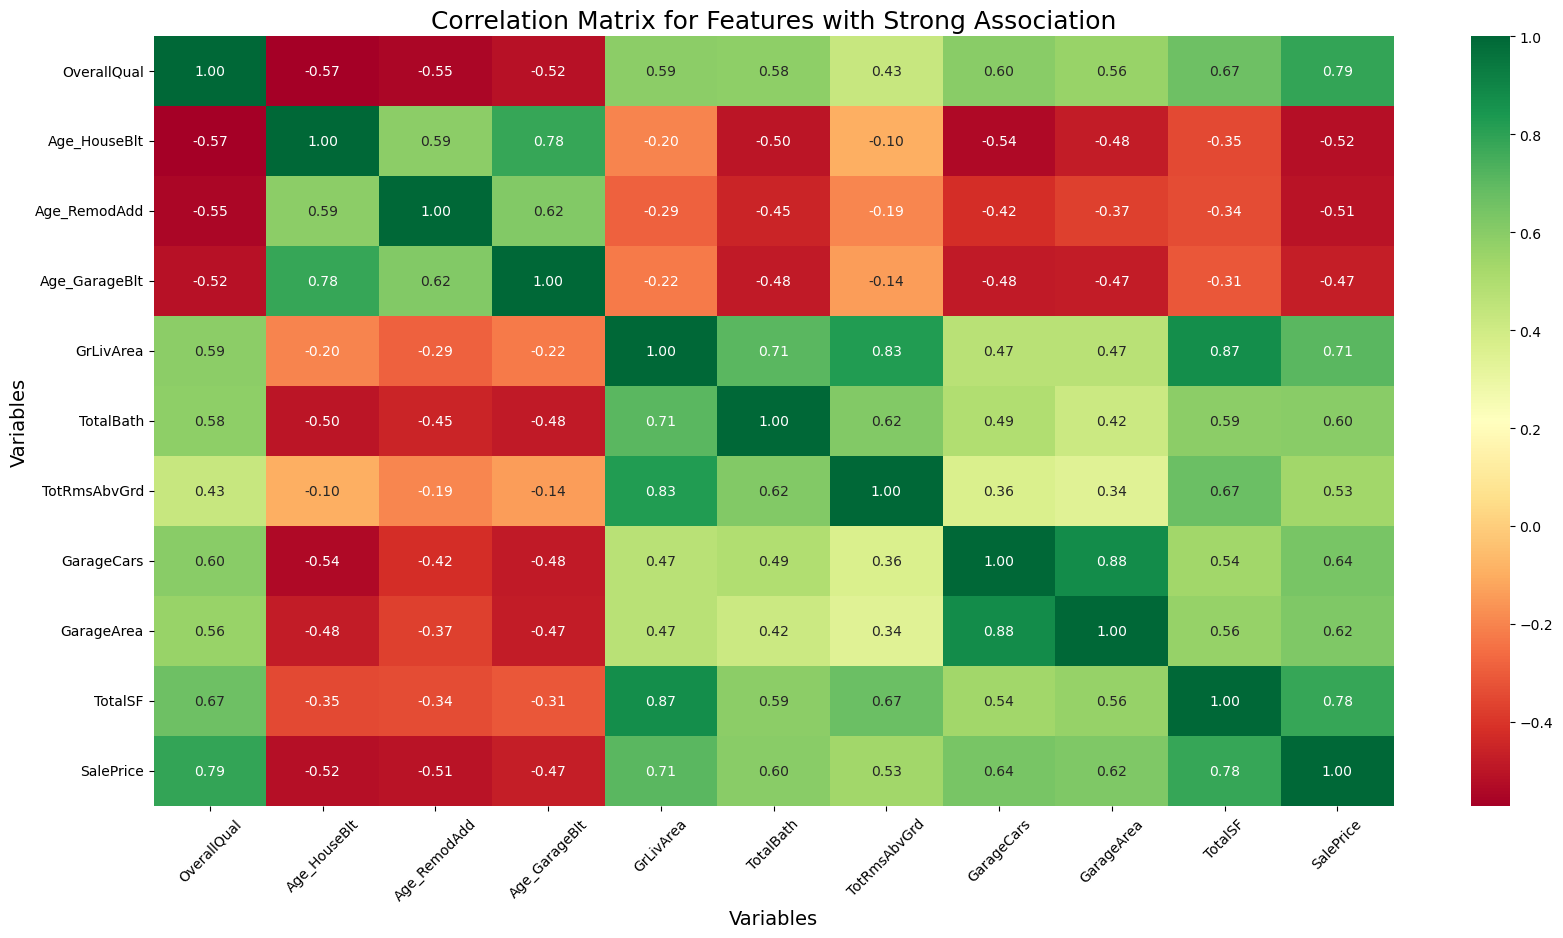

In [32]:
# After reviweing heat map above with all the numerical features and finding strenght relationship among features with SalePrice,
# the amount of 0.5 and over, the new heat map with picked features was prepared.
feature_with_strong_Asso = ['OverallQual', 'Age_HouseBlt','Age_RemodAdd',  'Age_GarageBlt', 
                            'GrLivArea', 'TotalBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea','TotalSF', 'SalePrice']
#Corrolation map with Pearson method
train_corr = train_cleaned_feng[feature_with_strong_Asso]
plt.figure(figsize=(20,10))
numeric_df = train_corr.select_dtypes(include=['float', 'int'])
corr= numeric_df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True , fmt='.2f')

plt.title('Correlation Matrix for Features with Strong Association', fontsize=18)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)

plt.show()

### Insights for Correlation  chart after Feature engineering, I can directly use these features for modeling, but let dive more in dataset!
 - Age related features show strong negative relationship with price and other features.

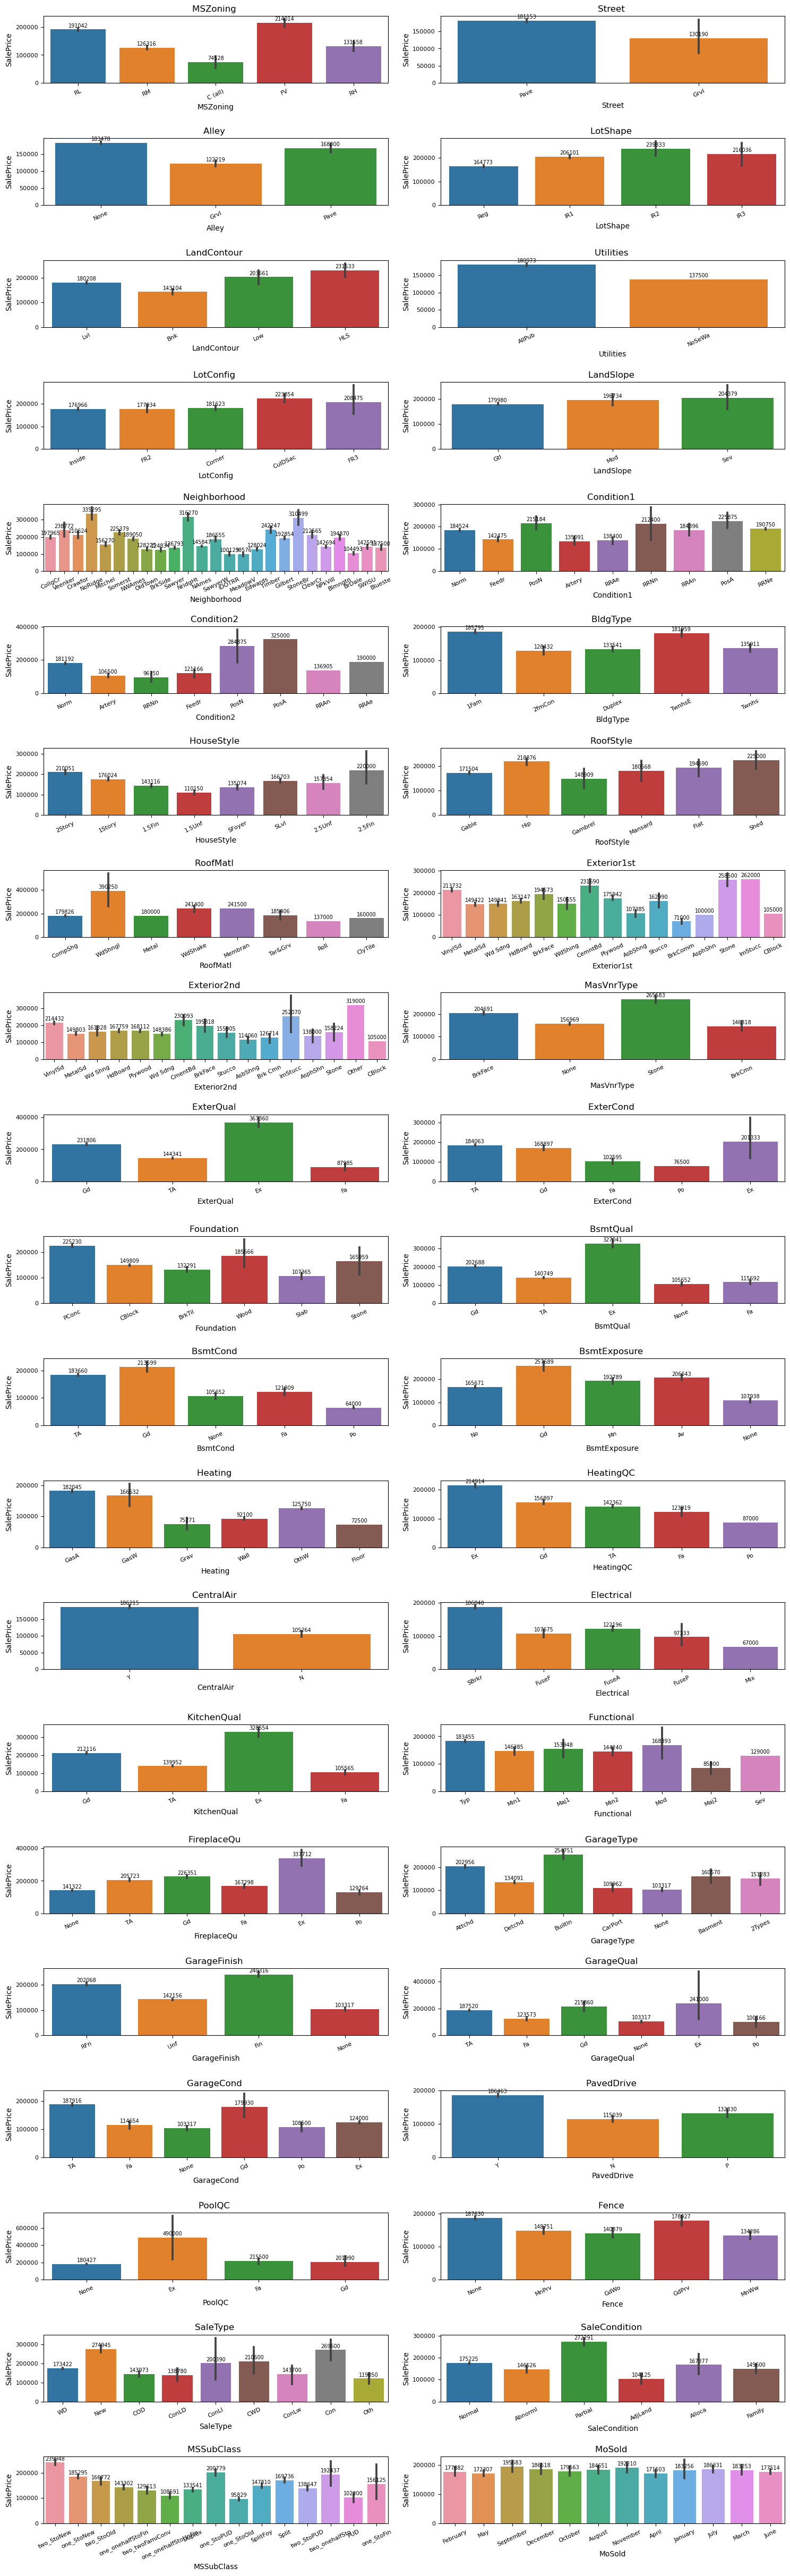

In [33]:
# Establish barchart to Visualize catfeatures within an overview to find out the relationship between
#  catfeatures and Price also type of catfeatures if need some feature engineering or ordinal encoding
# I added two new features created by feature engineering

plt.figure(figsize=(15, 50))

# Columns to plot
catcolumns = [ 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition', 'MSSubClass', 'MoSold']

for i, feature in enumerate(catcolumns, 1):
    plt.subplot(22,2, i)  
    ax = sns.barplot(x=feature, y='SalePrice', data=train_cleaned_feng) 
    plt.title(f'{feature} ')
    plt.xlabel(f'{feature}')
    plt.xticks(fontsize=8, rotation=25)
    plt.yticks(fontsize=8)
    plt.ylabel('SalePrice')

    # Annotate the bars in each subplot
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  # Annotating count as integer
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=7, color='black', 
                    xytext=(0, 5), textcoords='offset points')

# Adjust layout
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.tight_layout()
plt.show()

## **Exploring some of the most important `categorical variables` by vizualization on corrolation chart**

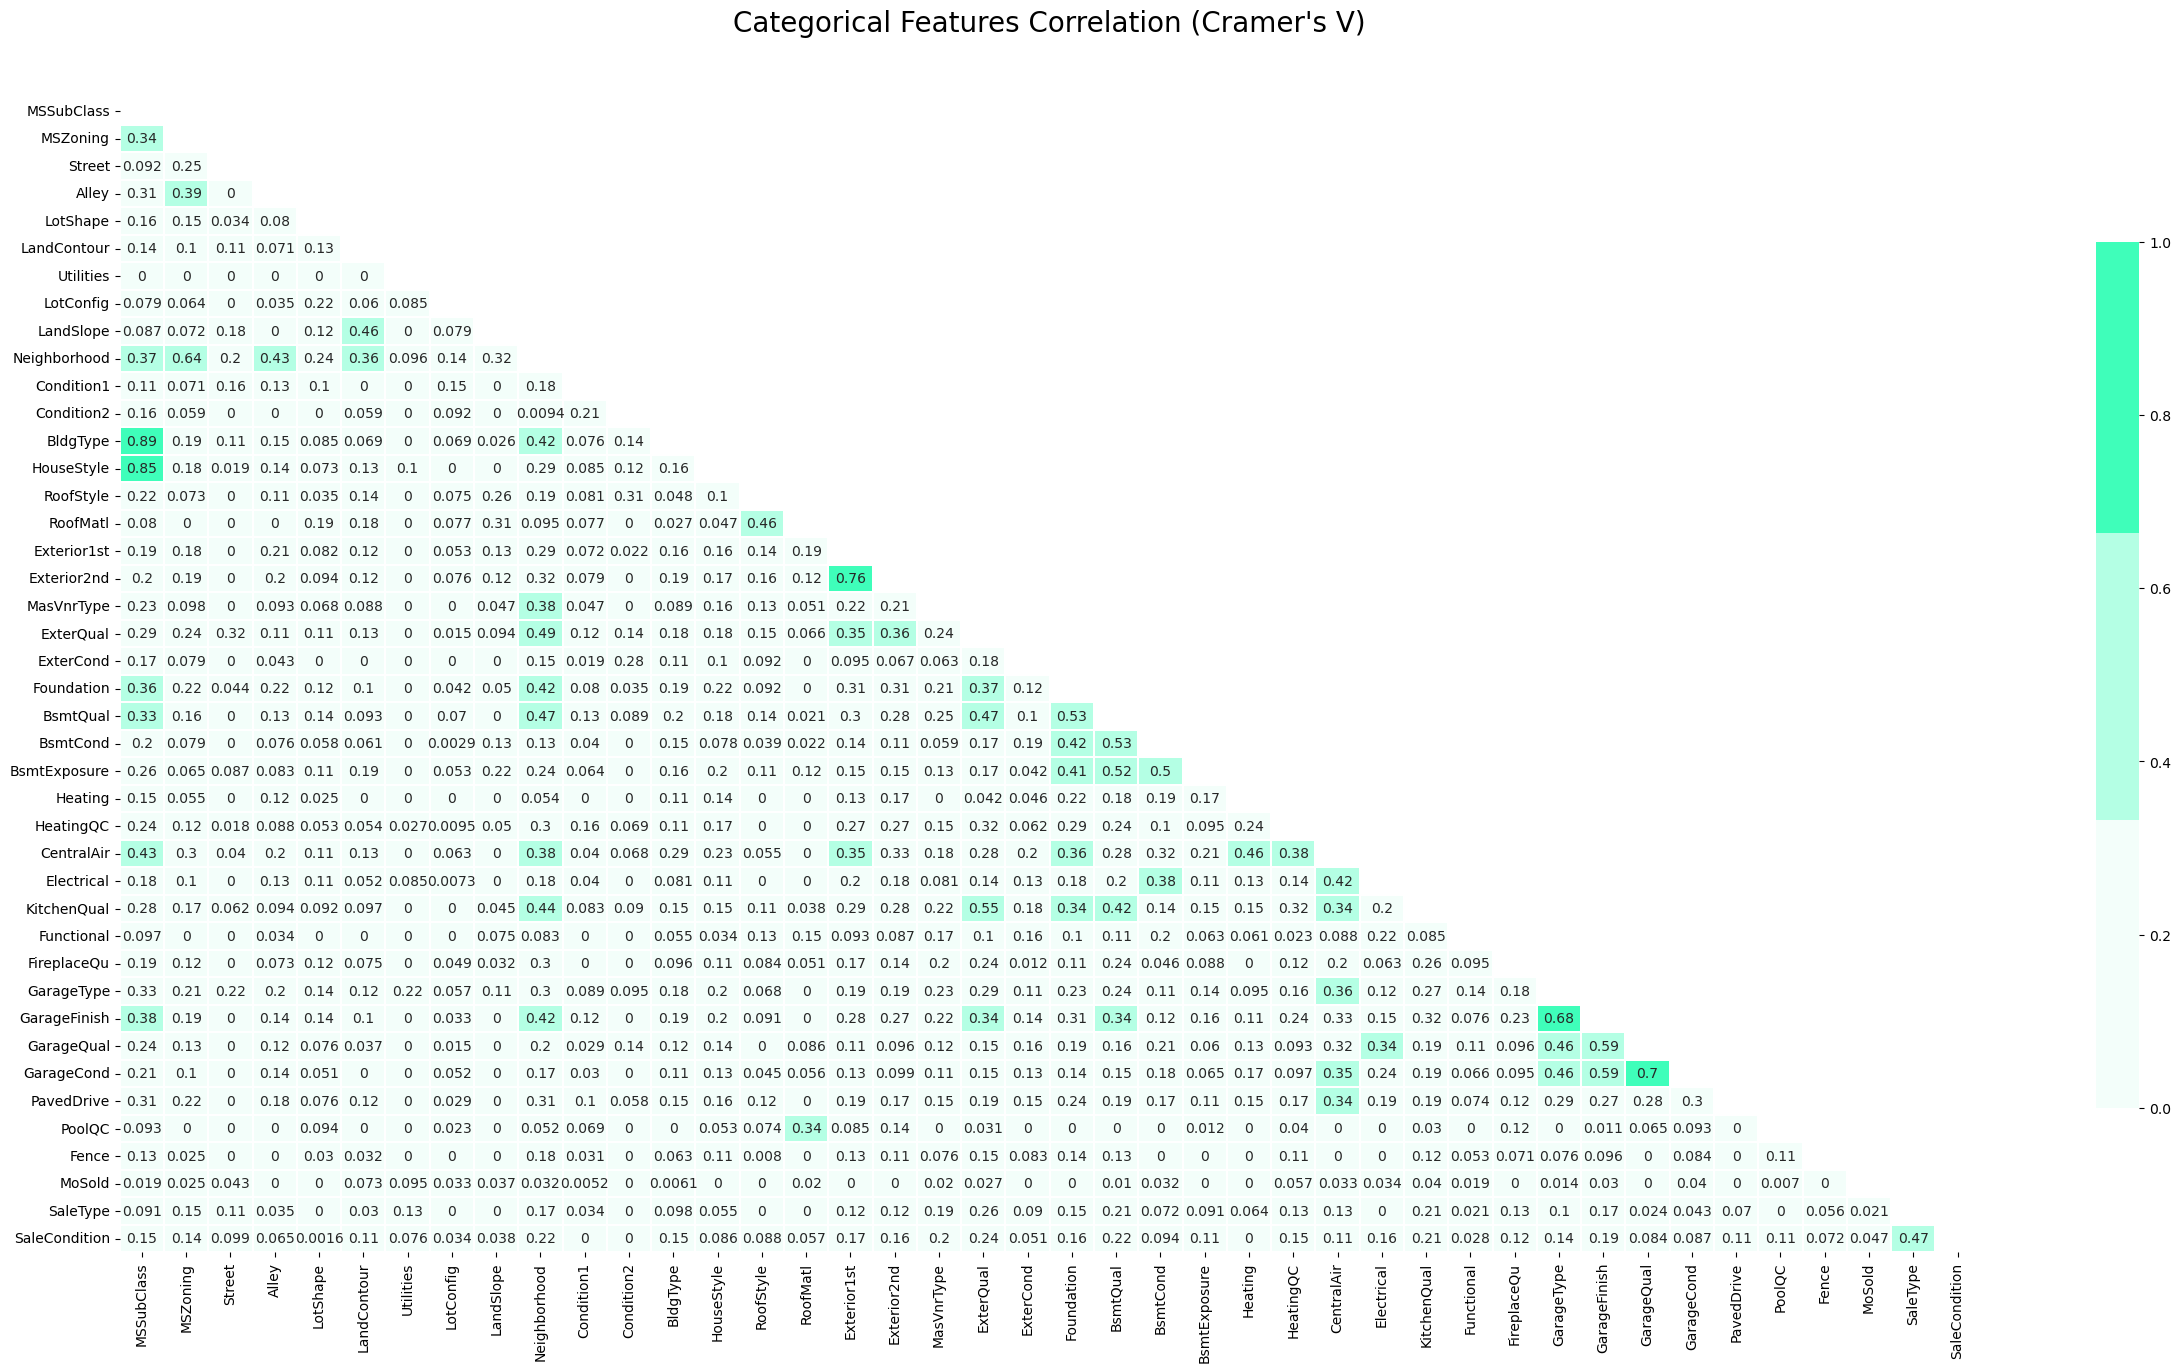

In [34]:
# Corrolation with Cramér's V Calculation
# Cramér's V calculation function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Categorical columns
catcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure','Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MoSold', 'SaleType', 'SaleCondition']


# Calculate Cramér's V for all pairs
cramers_results = np.zeros((len(catcolumns), len(catcolumns)))
for i, col1 in enumerate(catcolumns):
    for j, col2 in enumerate(catcolumns):
        cramers_results[i, j] = cramers_v(train_cleaned_feng[col1], train_cleaned_feng[col2])

# Create a DataFrame of results
cramers_df = pd.DataFrame(cramers_results, columns=catcolumns, index=catcolumns)

# Plot the heatmap
mask = np.triu(np.ones_like(cramers_df, dtype=bool))
f, ax = plt.subplots(figsize=(30, 15))
cmap = sns.color_palette(['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA'], as_cmap=True)
sns.heatmap(cramers_df, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y=1.05)
plt.show()

## Insights from correlation chart for Categorical Data
Features with high association could lead to multicollinearity, for Example below features show high association (0.5-0.7);
- `BldgType`, `HouseStyle` and `MsSubClass` 
- `GarageQual` and `GarageCond`, `GarageQual` and `GarageFinish`, `GarageType` and `GarageFinish`
- `BsmtFinishType2` and `BsmtQual`, `BsmtFinishType2` and `BsmtExposure`,  `BsmtFinishType2` and `BsmtCond` 
- `BsmtFinishType1` and `BsmtQual`, `BsmtFinishType1` and `BsmtExposure`,  `BsmtFinishType1` and `BsmtCond`
- `ExteriorQuql` and `Neighborhoud`, `Fondation`
- `Exterior1st` and `Exterior2nd`

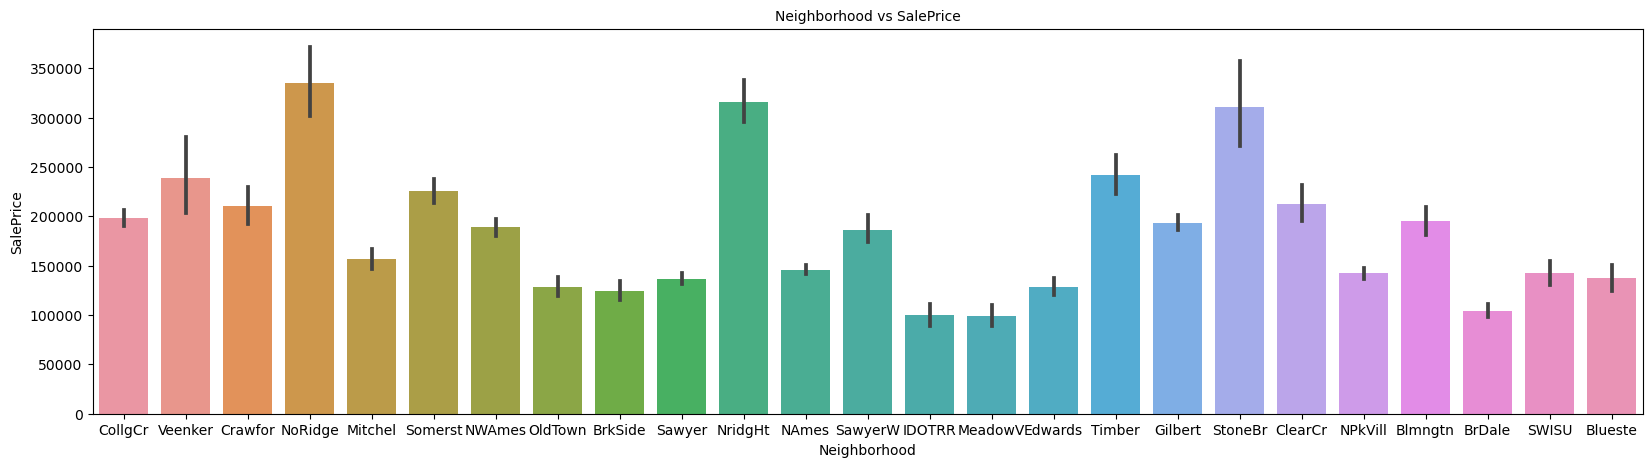

In [35]:
# Create a barplot to see frequency and relationship of obsrvation elements with price in Neighborhood feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='Neighborhood', y='SalePrice', data=train_cleaned_feng, ax=ax)
ax.set_title('Neighborhood vs SalePrice', fontsize=10)
ax.set_xlabel('Neighborhood', fontsize=10)
ax.set_ylabel('SalePrice', fontsize=10)
plt.show()

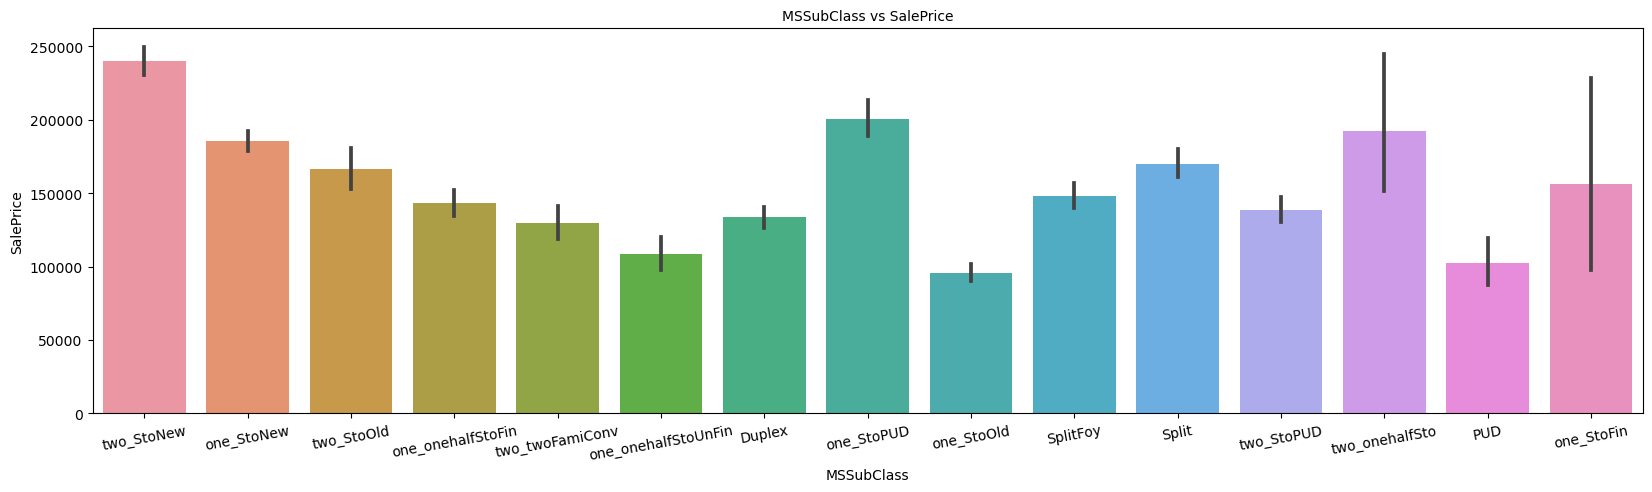

In [36]:
# Create a barplot to see frequency and relationship of every obsrvation with price in MSSubClass feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='MSSubClass', y='SalePrice', data=train_cleaned_feng, ax=ax)
ax.set_title('MSSubClass vs SalePrice', fontsize=10)
ax.set_xlabel('MSSubClass', fontsize=10)
plt.xticks(fontsize=10, rotation=10)
ax.set_ylabel('SalePrice', fontsize=10)
plt.show()

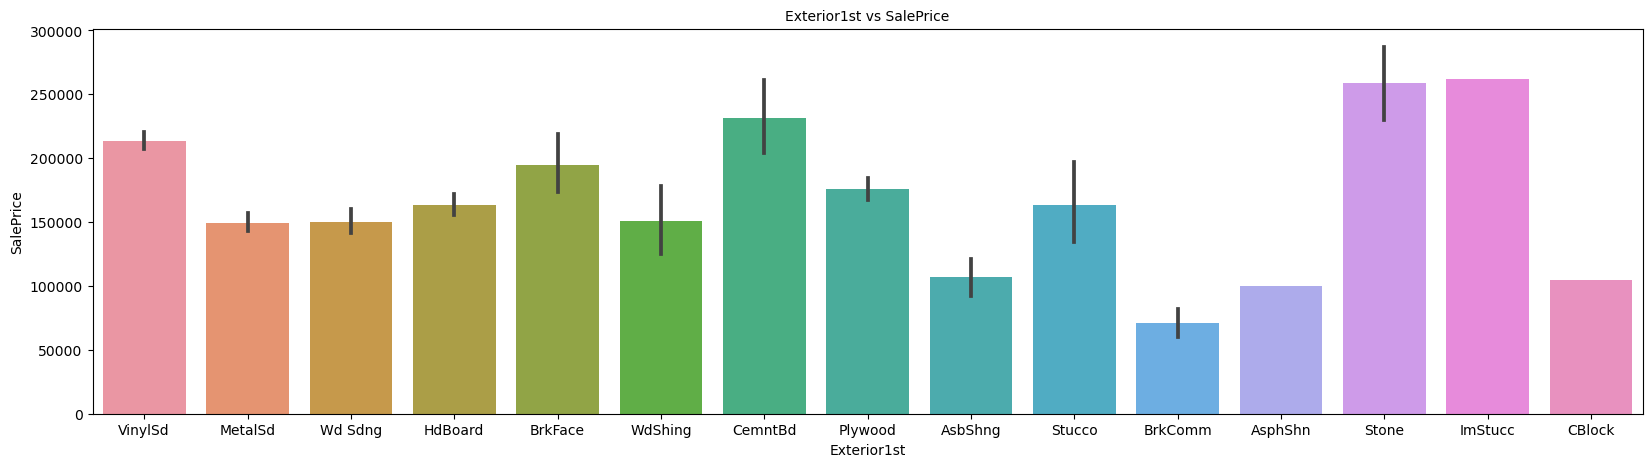

In [37]:
# Create a barplot to see frequency and relationship of every obsrvation with price in Exterior1st(Exterior covering on house) feature
fig, ax= plt.subplots(figsize=(20, 5))
sns.barplot(x='Exterior1st', y='SalePrice', data=train_cleaned_feng)
ax.set_title('Exterior1st vs SalePrice', fontsize=10)
ax.set_xlabel('Exterior1st', fontsize=10)
plt.show()

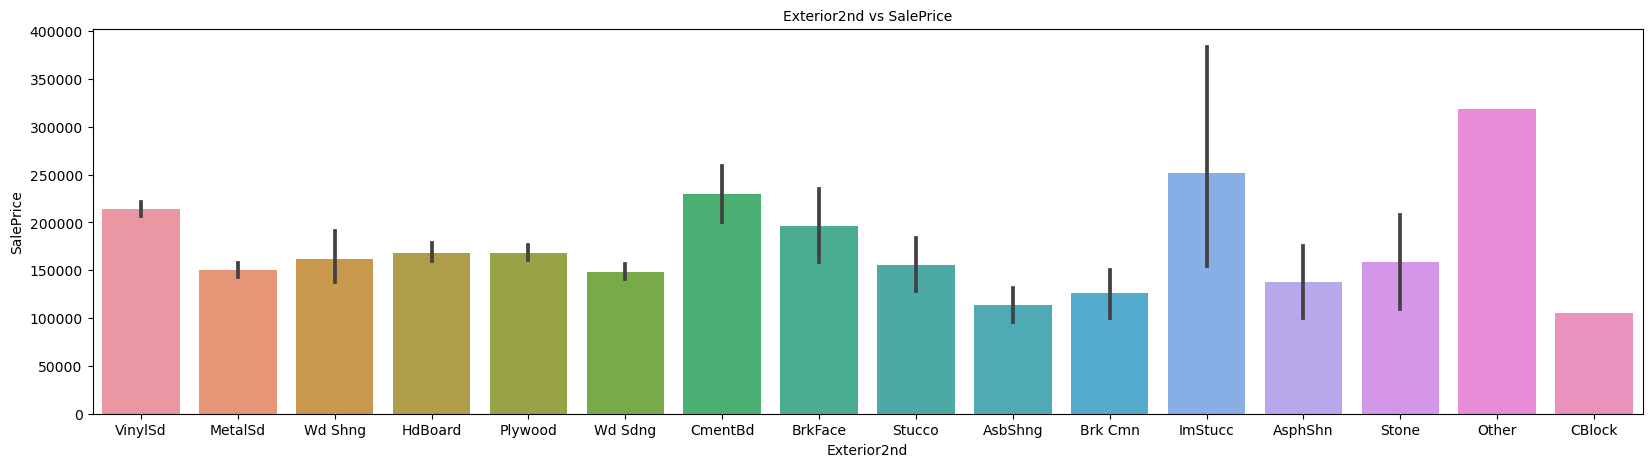

In [38]:
# Create a barplot to see frequency and relationship of every obsrvation with price in Exterior2nd(Exterior covering on house (if more than one material)) feature
fig, ax= plt.subplots(figsize=(20, 5))
sns.barplot(x='Exterior2nd', y='SalePrice', data=train_cleaned_feng)
ax.set_title('Exterior2nd vs SalePrice', fontsize=10)
ax.set_xlabel('Exterior2nd', fontsize=10)
plt.show()

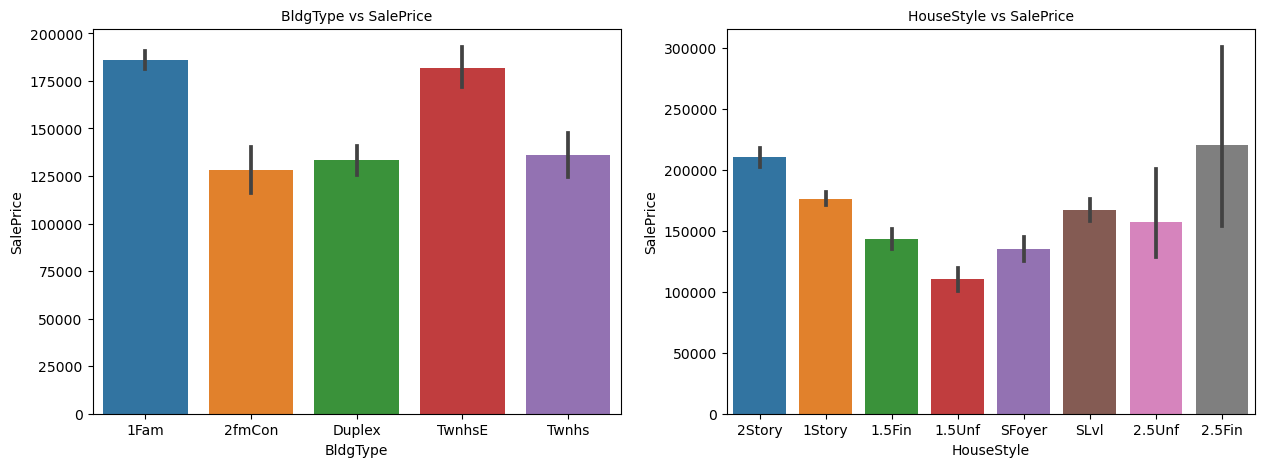

In [ ]:
# Create a bar plot to check features frequency and relationship of these two featureswith price
fig, ax= plt.subplots(1,2, figsize=(15, 5))
sns.barplot(x='BldgType', y='SalePrice', data=train_cleaned_feng, ax=ax[0])
sns.barplot(x='HouseStyle', y='SalePrice', data=train_cleaned_feng, ax=ax[1])
ax[0].set_title('BldgType vs SalePrice', fontsize=10)
ax[0].set_xlabel('BldgType', fontsize=10)
ax[1].set_title('HouseStyle vs SalePrice', fontsize=10)
ax[1].set_xlabel('HouseStyle', fontsize=10)
plt.show()

In [ ]:
#To get the two maximum prices from a DataFrame (df), I use the .nlargest() method or
top_2_prices = df['SalePrice'].nlargest(2)
print(top_2_prices)

691     755000.0
1182    745000.0
Name: SalePrice, dtype: float64


# Scatter plot to show extrem house price

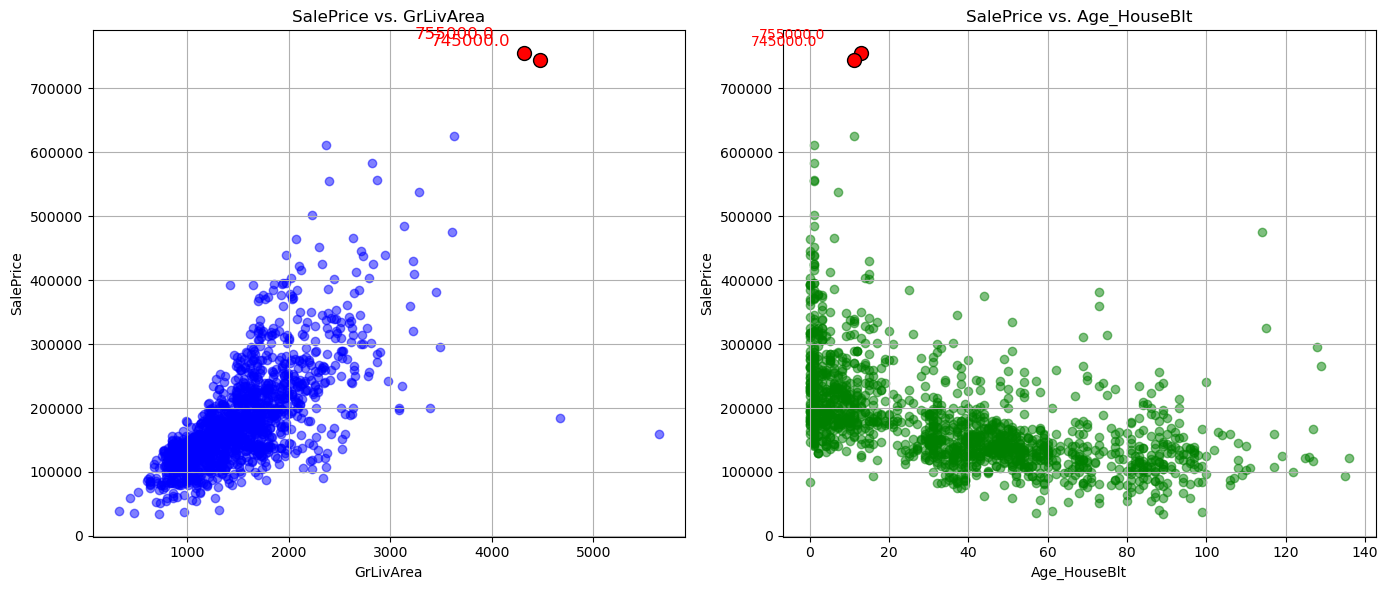

In [40]:
# Find the two rows with the highest SalePrice
top_2_prices = train_cleaned_feng.nlargest(2, 'SalePrice')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot of GrLivArea vs. SalePrice (on first subplot)
axs[0].scatter(train_cleaned_feng['GrLivArea'], train_cleaned_feng['SalePrice'], alpha=0.5, color='blue', label='GrLivArea')
axs[0].scatter(top_2_prices['GrLivArea'], top_2_prices['SalePrice'], color='red', s=100, edgecolors='black', label='Top 2 Sale Prices')
axs[0].set_xlabel("GrLivArea")
axs[0].set_ylabel("SalePrice")
axs[0].set_title("SalePrice vs. GrLivArea")
axs[0].grid(True)

# Annotate the top 2 points on the first subplot
for _, row in top_2_prices.iterrows():
    axs[0].annotate(f"{row['SalePrice']}", 
                    (row['GrLivArea'], row['SalePrice']), 
                    textcoords="offset points", xytext=(-50,10), ha='center', fontsize=12, color='red')

# Scatter plot of Age_HousBlt vs. SalePrice (on second subplot)
axs[1].scatter(train_cleaned_feng['Age_HouseBlt'], train_cleaned_feng['SalePrice'], alpha=0.5, color='green', label='Age_HouseBlt')
axs[1].scatter(top_2_prices['Age_HouseBlt'], top_2_prices['SalePrice'], color='red', s=100, edgecolors='black', label='Top 2 Sale Prices')
axs[1].set_xlabel("Age_HouseBlt")
axs[1].set_ylabel("SalePrice")
axs[1].set_title("SalePrice vs. Age_HouseBlt")
axs[1].grid(True)

# Annotate the top 2 points on the second subplot
for _, row in top_2_prices.iterrows():
    axs[1].annotate(f"{row['SalePrice']}", 
                    (row['Age_HouseBlt'], row['SalePrice']), 
                    textcoords="offset points", xytext=(-50,10), ha='center', fontsize=10, color='red')

# Adjust layout for better spacing between the plots
plt.tight_layout()
plt.show()


## Drop two extreme house price 

In [41]:
# Find the indexes of the two highest SalePrice values
top_2_indexes = train_cleaned_feng.nlargest(2, 'SalePrice').index

# Drop these rows from the DataFrame
train_cleaned_feng = train_cleaned_feng.drop(index=top_2_indexes)
print(train_cleaned_feng.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 1458
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1457 non-null   object 
 1   MSZoning          1457 non-null   object 
 2   LotFrontage       1457 non-null   float64
 3   LotArea           1457 non-null   int64  
 4   Street            1457 non-null   object 
 5   Alley             1457 non-null   object 
 6   LotShape          1457 non-null   object 
 7   LandContour       1457 non-null   object 
 8   Utilities         1457 non-null   object 
 9   LotConfig         1457 non-null   object 
 10  LandSlope         1457 non-null   object 
 11  Neighborhood      1457 non-null   object 
 12  Condition1        1457 non-null   object 
 13  Condition2        1457 non-null   object 
 14  BldgType          1457 non-null   object 
 15  HouseStyle        1457 non-null   object 
 16  OverallQual       1457 non-null   int64  
 17  

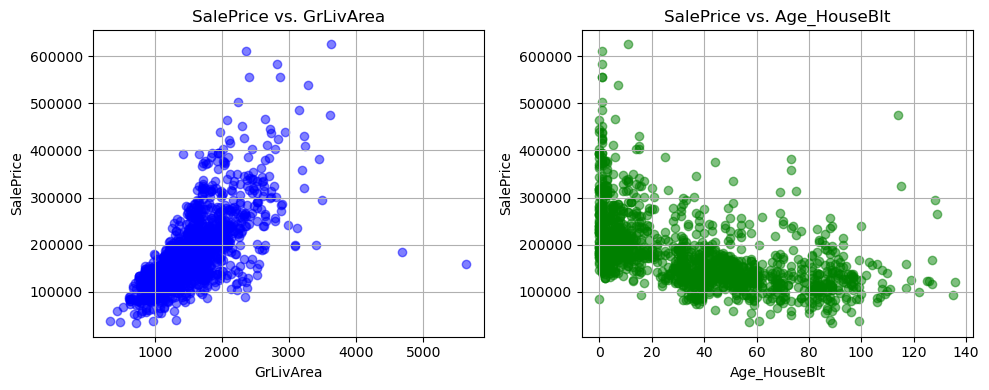

In [42]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot of GrLivArea vs. SalePrice (on first subplot)
axs[0].scatter(train_cleaned_feng['GrLivArea'], train_cleaned_feng['SalePrice'], alpha=0.5, color='blue', label='GrLivArea')
axs[0].set_xlabel("GrLivArea")
axs[0].set_ylabel("SalePrice")
axs[0].set_title("SalePrice vs. GrLivArea")
axs[0].grid(True)

# Scatter plot of Age_HousBlt vs. SalePrice (on second subplot)
axs[1].scatter(train_cleaned_feng['Age_HouseBlt'], train_cleaned_feng['SalePrice'], alpha=0.5, color='green', label='Age_HouseBlt')
axs[1].set_xlabel("Age_HouseBlt")
axs[1].set_ylabel("SalePrice")
axs[1].set_title("SalePrice vs. Age_HouseBlt")
axs[1].grid(True)

# Adjust layout for better spacing between the plots
plt.tight_layout()
plt.show()


## Two extreme price values droped

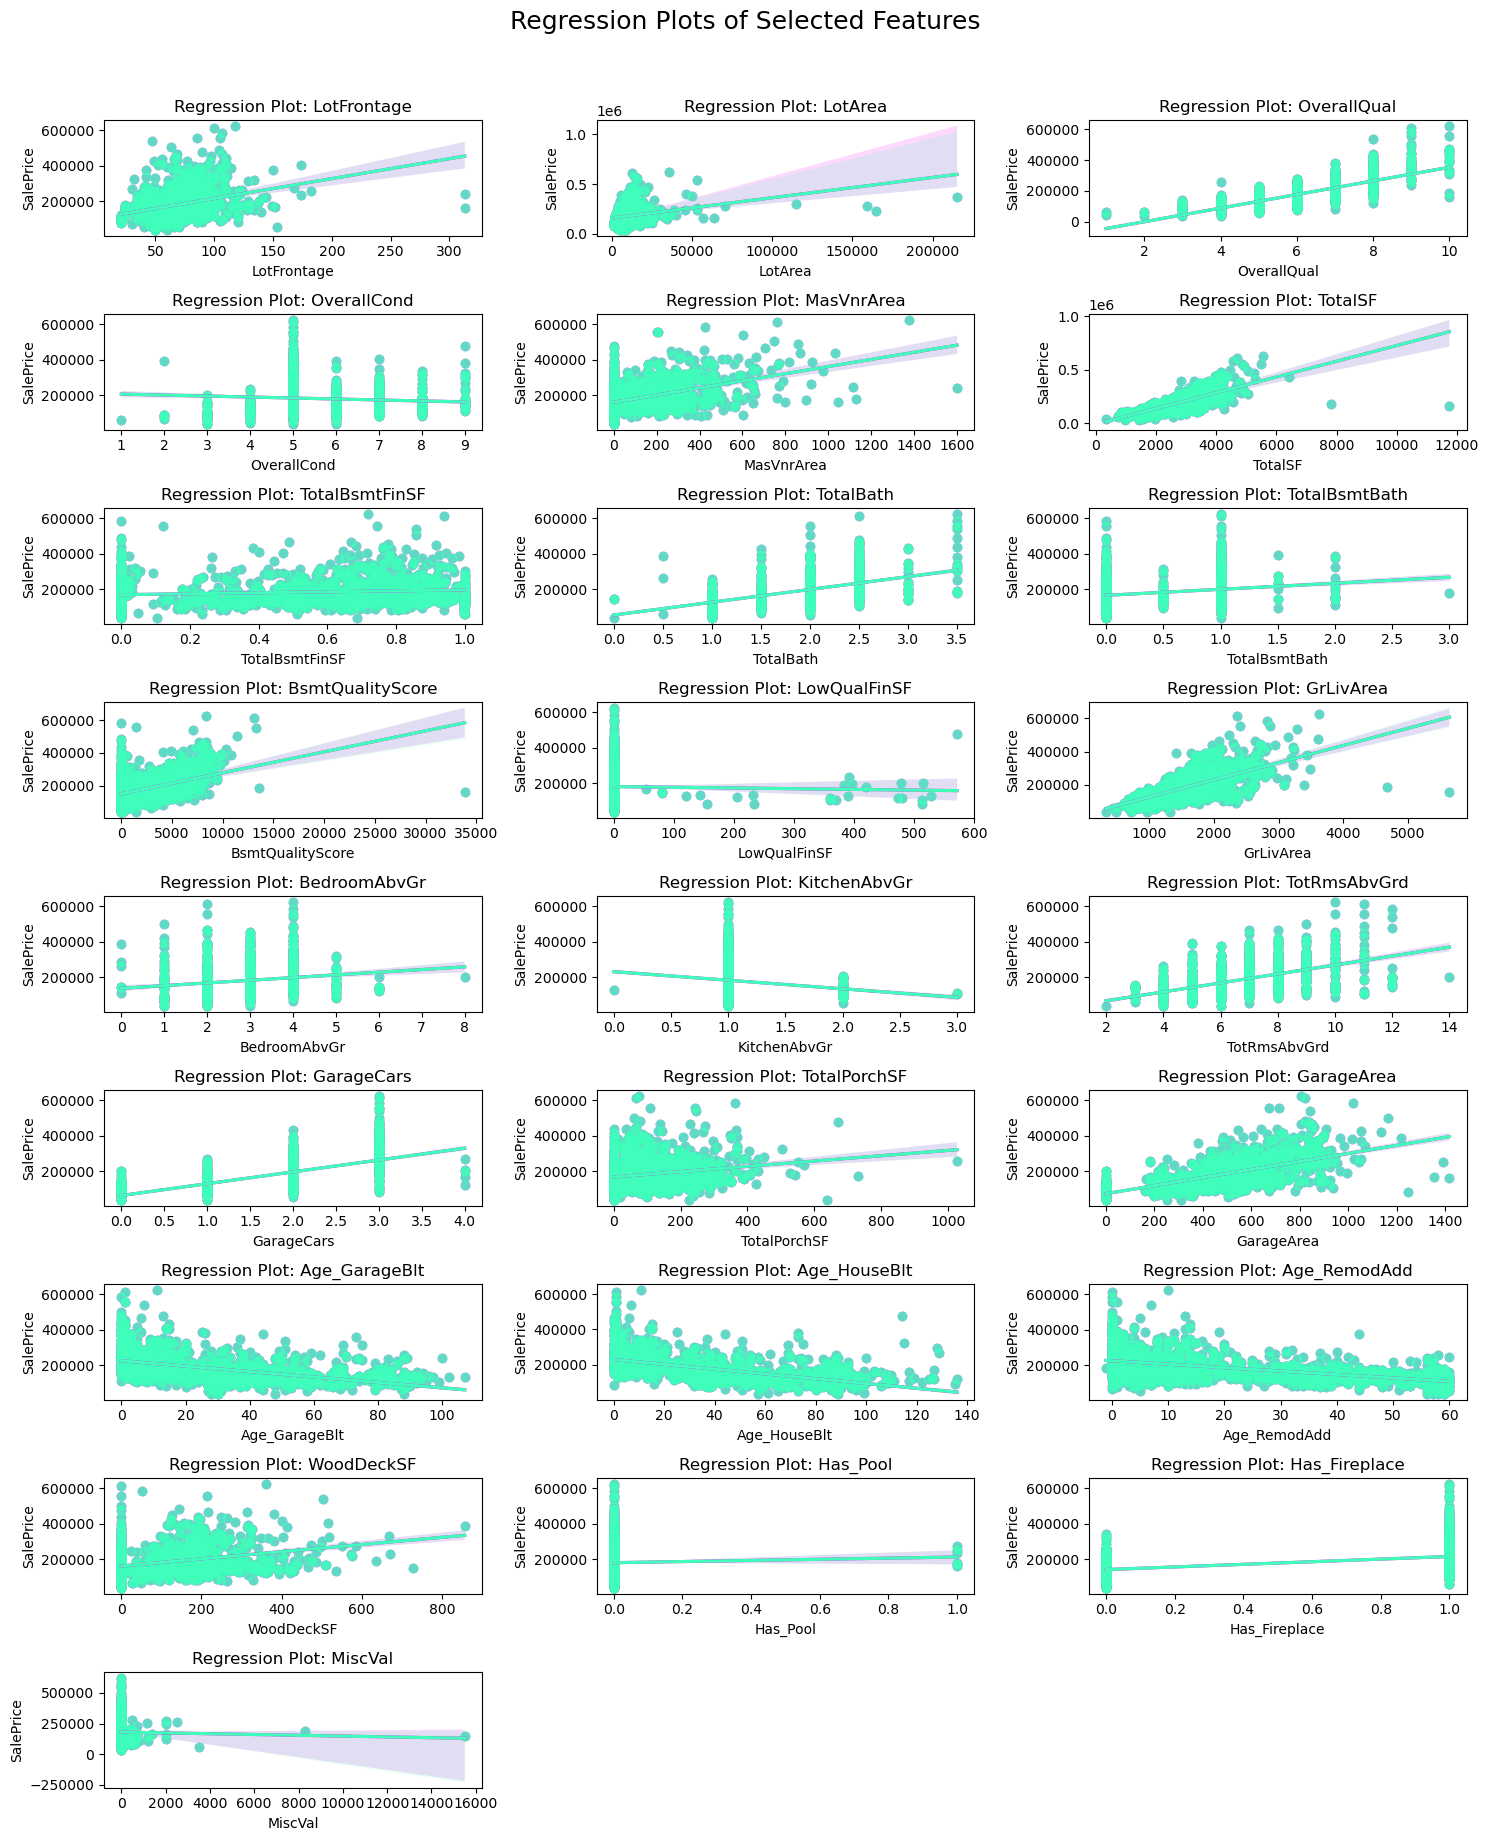

In [43]:
#develpe Regression plot 
fig, axes = plt.subplots(9, 3, figsize=(15, 18))  # Adjusting grid to fit 36 numerical features
axes = axes.flatten()  # Flattening for easier iteration

mypal = ['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA']

numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond','MasVnrArea','TotalSF', 'TotalBsmtFinSF', 'TotalBath','TotalBsmtBath','BsmtQualityScore',
       'LowQualFinSF', 'GrLivArea',  'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'GarageCars','TotalPorchSF', 'GarageArea','Age_GarageBlt', 'Age_HouseBlt', 'Age_RemodAdd', 'WoodDeckSF','Has_Pool', 'Has_Fireplace',
       'MiscVal']

# Loop through each feature and plot regression
for i, col in enumerate(numerical_features):
    if i < len(axes):  # Ensure no index out of bounds
        sns.regplot(data=train_cleaned_feng, x=col, y='SalePrice', ax=axes[i], 
                    color=mypal[0], label='SalePrice=1')
        sns.regplot(data=train_cleaned_feng, x=col, y='SalePrice', ax=axes[i], color=mypal[5])

        axes[i].set_title(f'Regression Plot: {col}')
        
# Hiding unused subplots
for i in range(len(numerical_features), len(axes)):
     axes[i].axis('off')

# Overall title
plt.suptitle('Regression Plots of Selected Features', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### <font color='#7FFFD4'>**5.3 Standardization and normalization**</font>

In [ ]:
#scale the numerical features to ensure they’re on a similar scale.
#define numerical features
numerical_features = train_cleaned_feng.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'MiscVal',
       'SalePrice', 'Age_HouseBlt', 'Age_RemodAdd', 'Age_GarageBlt',
       'TotalBath', 'TotalPorchSF', 'TotalBsmtBath', 'TotalSF',
       'TotalBsmtFinSF', 'BsmtQualityScore'],
      dtype='object')

In [46]:

# Initialize scaler
scaler = StandardScaler()

numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'MiscVal',
       'SalePrice', 'Age_HouseBlt', 'Age_RemodAdd', 'Age_GarageBlt',
       'TotalBath', 'TotalPorchSF', 'TotalBsmtBath', 'TotalSF',
       'TotalBsmtFinSF', 'BsmtQualityScore']


# Make a copy of the dataframe to avoid modifying the original
df_scaled = df.copy()

# Ensure all selected numerical columns exist in df_scaled
numerical_features = [col for col in numerical_features if col in df_scaled.columns]

# Convert to float (necessary for scaling)
df_scaled[numerical_features] = df_scaled[numerical_features].astype(float)

# Initialize and apply StandardScaler
scaler = StandardScaler()
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])

# Verify scaling

df_scaled.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  two_StoNew       RL    -0.191689 -0.217851   Pave  None      Reg   
1  one_StoNew       RL     0.511954 -0.072042   Pave  None      Reg   
2  two_StoNew       RL    -0.050961  0.137163   Pave  None      IR1   
3  two_StoOld       RL    -0.426237 -0.078381   Pave  None      IR1   
4  two_StoNew       RL     0.699592  0.518804   Pave  None      IR1   

  LandContour Utilities LotConfig  ... Age_RemodAdd Age_GarageBlt TotalBath  \
0         Lvl    AllPub    Inside  ...    -0.886669     -0.988706  1.154222   
1         Lvl    AllPub       FR2  ...     0.358008      0.055145  0.376209   
2         Lvl    AllPub    Inside  ...    -0.838797     -0.908409  1.154222   
3         Lvl    AllPub    Corner  ...     0.597369     -0.868261 -1.179818   
4         Lvl    AllPub       FR2  ...    -0.743053     -0.868261  1.154222   

  TotalPorchSF TotalBsmtBath   TotalSF  TotalBsmtFinSF  Has_Pool  \
0    -0.261877      1.036956  0.022577        1.064998         0   
1    -0.827204      0.076677 -0.029621        0.928886         0   
2    -0.437962      1.036956  0.196569        0.250049         0   
3     2.017968      1.036956 -0.093004       -0.416930         0   
4    -0.048720      1.036956  0.988234        0.370773         0   

  Has_Fireplace BsmtQualityScore  
0             0         0.677770  
1             1         0.924143  
2             1         0.181260  
3             1        -0.508961  
4             1         0.562670  

[5 rows x 69 columns]

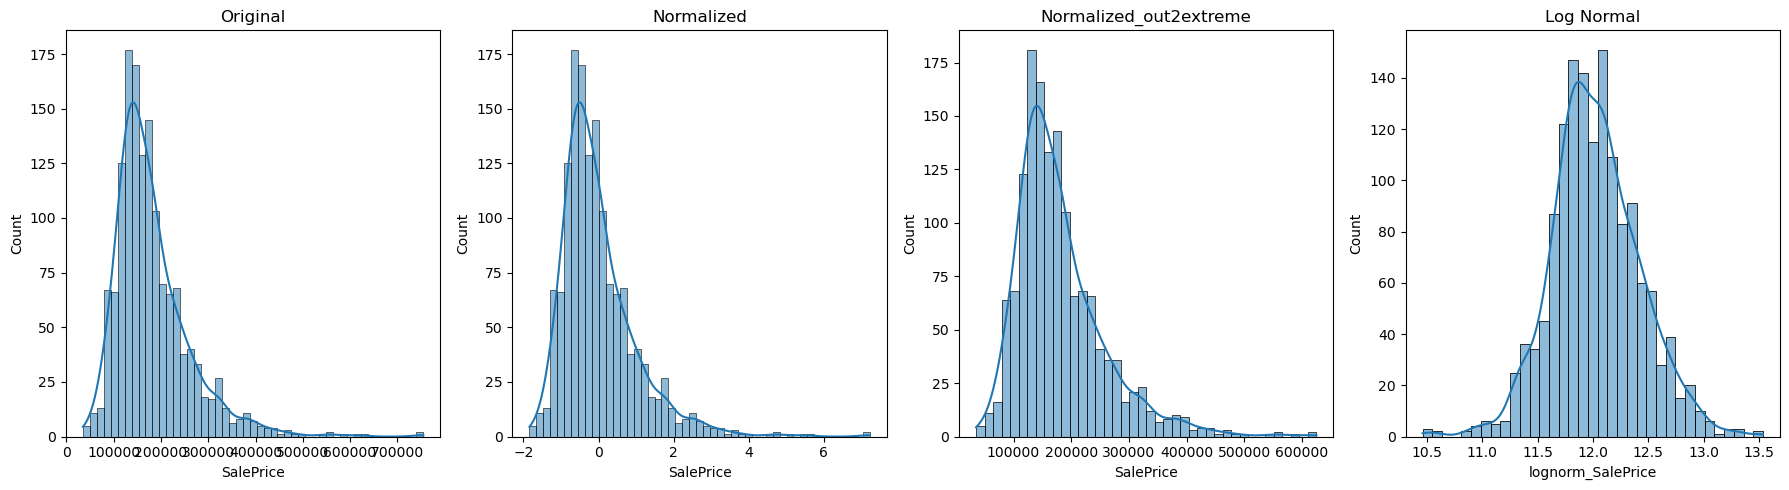

In [47]:
#HistPlot of SalePrice, target data

# Apply transformations only on training data
df.loc[df['train_test'] == 1, 'lognorm_SalePrice'] = np.log(df.loc[df['train_test'] == 1, 'SalePrice'] + 1)

# Filtering only training data for visualization
train_cleaned = df[df['train_test'] == 1]

# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(train_cleaned['SalePrice'], kde=True, ax=ax[0])
ax[0].set_title('Original')

sns.histplot(df_scaled['SalePrice'], kde=True, ax=ax[1])
ax[1].set_title('Normalized')

sns.histplot(train_cleaned_feng['SalePrice'], kde=True, ax=ax[2])
ax[2].set_title('Normalized_out2extreme')

sns.histplot(df['lognorm_SalePrice'], kde=True, ax=ax[3])
ax[3].set_title('Log Normal')

plt.tight_layout()
plt.show()

`The sale prices are right skewed as few people can afford very expensive houses.` 

### <font color='#7FFFD4'>**5.4 Encoding_ labeling**</font>
- Define Ordinality of Categorical features 
   - I have converted cat-variables into ordinal integers if there is clear ordinality. The rest was converted into numeric by using dummeis encoding.

In [48]:
# Define ordinal categories for each feature
ordinal_categories = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# Ensure all ordinal columns are treated as categorical
for col, order in ordinal_categories.items():
    
    # Initialize the encoder with the custom order
    encoder = OrdinalEncoder(categories=[order])

    # Reshape the column to 2D and transform
    df_scaled[col] = encoder.fit_transform(df_scaled[[col]])


In [49]:
categorical_demmy =  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating','CentralAir', 'Electrical',
       'Functional', 'GarageType', 'PavedDrive', 'MoSold', 'SaleType', 'SaleCondition']

In [50]:
# Create dummy variables for categorical features
dummies = pd.get_dummies(df_scaled[['MSSubClass','MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'MasVnrType',
    'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 
     'PavedDrive', 'SaleType', 'SaleCondition', 
    'MoSold']])
dummies.shape

(2918, 211)

In [51]:
# Drop specified columns from 'dummies' and concatenate with 'df'
df_final = pd.concat([df_scaled, dummies], axis=1)

df_final.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  two_StoNew       RL    -0.191689 -0.217851   Pave  None      Reg   
1  one_StoNew       RL     0.511954 -0.072042   Pave  None      Reg   
2  two_StoNew       RL    -0.050961  0.137163   Pave  None      IR1   
3  two_StoOld       RL    -0.426237 -0.078381   Pave  None      IR1   
4  two_StoNew       RL     0.699592  0.518804   Pave  None      IR1   

  LandContour Utilities LotConfig  ... MoSold_December MoSold_February  \
0         Lvl    AllPub    Inside  ...           False            True   
1         Lvl    AllPub       FR2  ...           False           False   
2         Lvl    AllPub    Inside  ...           False           False   
3         Lvl    AllPub    Corner  ...           False            True   
4         Lvl    AllPub       FR2  ...            True           False   

  MoSold_January MoSold_July MoSold_June MoSold_March  MoSold_May  \
0          False       False       False        False       False   
1          False       False       False        False        True   
2          False       False       False        False       False   
3          False       False       False        False       False   
4          False       False       False        False       False   

   MoSold_November MoSold_October MoSold_September  
0            False          False            False  
1            False          False            False  
2            False          False             True  
3            False          False            False  
4            False          False            False  

[5 rows x 280 columns]

In [52]:
df_final.drop(columns=['MSSubClass','MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'MasVnrType',
    'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 
     'PavedDrive', 'SaleType', 'SaleCondition', 
    'MoSold'], inplace=True)
df_final.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       ...
       'MoSold_December', 'MoSold_February', 'MoSold_January', 'MoSold_July',
       'MoSold_June', 'MoSold_March', 'MoSold_May', 'MoSold_November',
       'MoSold_October', 'MoSold_September'],
      dtype='object', length=251)

## <font color='#FF9FD6'>**6 Modeling**</font>
### <font color='#7FFFD4'>**6.1 Base Model- Linear Regression**</font>

In [53]:
# Split back into train and test sets to basic modeling on train setdata after feature engineering
train_cleaned_feng_encod_scaled = df_final[df_final['train_test'] == 1].drop(['train_test', 'SalePrice'], axis=1)
test_cleaned_feng_encod_scaled = df_final[df_final['train_test'] == 0].drop(['train_test', 'SalePrice'], axis=1)

# Display first few rows for validation
print(train_cleaned_feng_encod_scaled.shape)
train_cleaned_feng_encod_scaled.head(2)

(1459, 249)


LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  ExterQual  \
0    -0.191689 -0.217851     0.645874    -0.507077    0.528778        3.0   
1     0.511954 -0.072042    -0.063445     2.188095   -0.567144        2.0   

   ExterCond  BsmtQual  BsmtCond  BsmtExposure  ...  MoSold_December  \
0        2.0       4.0       3.0           1.0  ...            False   
1        2.0       4.0       3.0           4.0  ...            False   

   MoSold_February  MoSold_January  MoSold_July  MoSold_June  MoSold_March  \
0             True           False        False        False         False   
1            False           False        False        False         False   

   MoSold_May  MoSold_November  MoSold_October  MoSold_September  
0       False            False           False             False  
1        True            False           False             False  

[2 rows x 249 columns]

In [55]:
# define X_train, X_test
X_train = train_cleaned_feng_encod_scaled
X_test = test_cleaned_feng_encod_scaled
y_train = df[df.train_test == 1].lognorm_SalePrice #Extracts the target variable (SalePrice) from the combined dataset for the training set. 

# Fit the model
lr_reg = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = lr_reg.predict(X_test)


# Make predictions on the training set to calculate RMSE
y_train_pred = lr_reg.predict(X_train)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Base Model with RMSE: {rmse:.4f}")

# Evaluate using R² score
score = lr_reg.score(X_train, y_train)  # R² score on the training set

print(f"Base Model with R² Score: {score:.4f}")

test_labels = test['Id']  # assuming the test DataFrame has the 'Id' column

# Create a DataFrame with the Id and weighted average predictions
test_price = pd.DataFrame({
    'Id': test_labels,
    'SalePrice': np.exp(y_pred)})

# Show a preview of the DataFrame
print(test_price.head(20))

# Save to CSV
test_price.to_csv('Test_price.csv', index=False)

Base Model with RMSE: 0.0963
Base Model with R² Score: 0.9419
      Id      SalePrice
0   1461  119503.889166
1   1462  160529.801500
2   1463  177925.725889
3   1464  202568.833640
4   1465  194954.230420
5   1466  172574.876865
6   1467  177322.145440
7   1468  164728.109438
8   1469  185597.829529
9   1470  123496.452178
10  1471  186330.122717
11  1472   98310.774035
12  1473   94825.146534
13  1474  149714.887575
14  1475  127002.652532
15  1476  349074.822045
16  1477  262326.274547
17  1478  291854.573551
18  1479  282966.827322
19  1480  532933.531572


#### <font color='#7FFFD4'>**6.1.1 Claculate residuals**</font>

RMSE on Training set: 0.15337013222233625


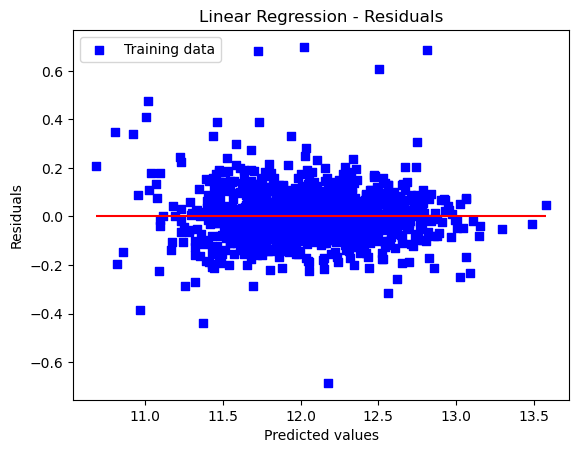

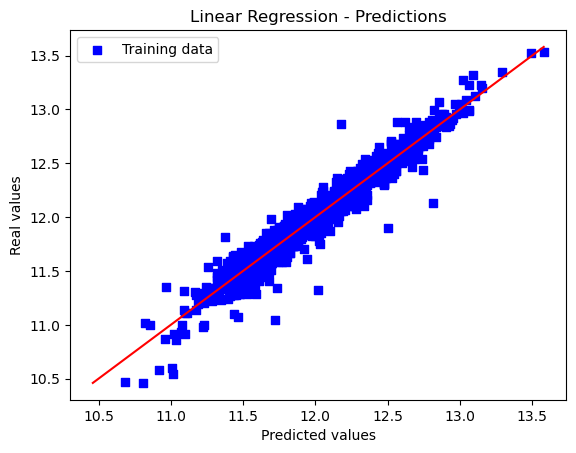

In [56]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Define RMSE function
def rmse_cv(model, X, y):
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring=scorer, cv=5))
    return rmse_scores.mean()

# Compute RMSE
print("RMSE on Training set:", rmse_cv(lr, X_train, y_train))

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c="blue", marker="s", label="Training data")
#plt.scatter(y_test_pred, y_test_pred - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Linear Regression - Residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=min(y_train_pred), xmax=max(y_train_pred), color="red")
plt.show()

# Plot predicted vs actual
plt.scatter(y_train_pred, y_train, c="blue", marker="s", label="Training data")
#plt.scatter(y_test_pred, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Linear Regression - Predictions")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")

# Plot perfect prediction line
min_val, max_val = min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], c="red")

plt.show()


### <font color='#7FFFD4'>**Insights from Claculate residuals**</font>

- The first plot shows the distribution of residuals (the differences between actual and predicted values). We're looking for a normal distribution centered around zero. The histogram suggests that the residuals are fairly normally distributed, but there might be a slight skewness to the right.

- The second plot shows the actual vs. predicted values. We'd like to see the points along the diagonal line, indicating that the predicted values are close to the actual values. While there is some scatter, many points do lie near the line, which is positive.


In [57]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

# Make predictions on the training set to calculate RMSE
y_train_pred = lr_reg.predict(X_train)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Ridge Model with RMSE: {rmse:.4f}")


# Make predictions
predictions = ridge.predict(X_test)

# Evaluate using R² score
score = ridge.score(X_train, y_train)  # R² score on the training set
print(f"Ridge Model with R² Score: {score:.4f}")

Ridge Model with RMSE: 0.0963
Ridge Model with R² Score: 0.9346


In [58]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

# Make predictions on the training set to calculate RMSE
y_train_pred = lr_reg.predict(X_train)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Lasso Model with RMSE: {rmse:.4f}")

# Evaluate using R² score
score = lasso.score(X_train, y_train)  # R² score on the training set

print(f"Lasso Model with R² Score: {score:.4f}")

Lasso Model with RMSE: 0.0963
Lasso Model with R² Score: 0.0000


#### **Lasso Model with R² Score: 0.0000** 
If Lasso model is showing an R² score of 0.0000, it likely means that model is performing no better than simply predicting the mean of the target variable. Here are a few possible reasons and ways to fix it:

- Possible Causes:
Over-Regularization (High Alpha Value)
- Lasso applies L1 regularization, which can shrink coefficients to zero. If alpha (λ) is too high, it might be penalizing the model too much, making all coefficients zero.

Irrelevant or Weak Features
- If features are not strongly correlated with the target variable, the model may fail to capture patterns.

Poor Data Scaling
- Lasso is sensitive to feature scaling. If the features are on different scales, it might lead to ineffective regularization.

Multicollinearity
- Highly correlated independent variables can cause instability in coefficient selection.

Incorrect Data Preprocessing
- Missing values, outliers, or categorical variables not encoded properly could be affecting the model. 
## **Based on correlation charts there is Multicollinearity in features, so Feature Importance is next step**

## <font color=#7FFFD4> **6.2 Predictive Modeling**</font>

### **Cross Validation**
### <font color='#7FFFD4'>**6.2.1 Train Lasso Model**</font>

In [88]:
# Define training and test sets
X_train = train_cleaned_feng_encod_scaled
X_test = test_cleaned_feng_encod_scaled
y_train = df[df.train_test == 1].lognorm_SalePrice  # Target variable

# Train Lasso Model
# Initialize Lasso model with a fixed alpha
lasso = Lasso(alpha=0.1)  # Adjust alpha as needed

# Fit the model
lasso.fit(X_train, y_train)

# Predict on test set
y_pred = lasso.predict(X_test)

# Step 4: Evaluate Model
cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)

# Compute negative MSE from cross-validation (5-fold)
cv_mse = -cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Compute RMSE
cv_rmse = np.sqrt(cv_mse)

# Compute R² scores from cross-validation
cv_r2 = cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2')

# Print results
print(f'CV Scores: {cv_scores}')
print(f'Cross-validated Mean Squared Error: {cv_mse.mean():.4f}')
print(f'Cross-validated Root Mean Squared Error: {cv_rmse.mean():.4f}')
print(f'Cross-validated R² Score: {cv_r2.mean():.4f}')

# Check feature importance (coefficients)
#feature_importance_lasso = pd.Series(lasso.coef_, index=X_train.columns)
#print("Feature Importance:\n", feature_importance_lasso)

# Plot feature importance
#feature_importance_lasso.plot(kind="bar", figsize=(30,15) )
#plt.title("Lasso Feature Importance")
#plt.show()


CV Scores: [0.72476173 0.73407889 0.71794205 0.69886716 0.70981852 0.72101163
 0.73178276 0.72476341 0.62185684 0.73507295]
Cross-validated Mean Squared Error: 0.0457
Cross-validated Root Mean Squared Error: 0.2129
Cross-validated R² Score: 0.7120


### <font color='#7FFFD4'>**6.2.1.1 Tune Best alpha to better performance Lasso**</font>

In [89]:
# Use LassoCV to find the best alpha
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=10).fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best Alpha: {best_alpha}")

# Train the final Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)


cv_scores_alpha = cross_val_score(lasso_cv, X_train, y_train, cv=10)
# Evaluate using cross-validation
cv_mse = -cross_val_score(lasso_best, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate RMSE
cv_rmse = np.sqrt(cv_mse)
cv_r2 = cross_val_score(lasso_best, X_train, y_train, cv=10, scoring='r2')

print(f'Lasso CV Scores: {cv_scores_alpha}')
print(f"Lasso_best_alpha, Cross-validated Mean Squared Error: {cv_mse.mean():.4f}")
print(f"Lasso_best_alpha, Cross-validated Root Mean Squared Error: {cv_rmse.mean():.4f}")
print(f"Lasso_best_alpha, Cross-validated R² Score: {cv_r2.mean():.4f}")


Best Alpha: 0.001
Lasso CV Scores: [0.89562905 0.93696956 0.93162999 0.82603705 0.89757704 0.91967543
 0.90174388 0.92560319 0.62262839 0.90353277]
Lasso_best_alpha, Cross-validated Mean Squared Error: 0.0194
Lasso_best_alpha, Cross-validated Root Mean Squared Error: 0.1336
Lasso_best_alpha, Cross-validated R² Score: 0.8761


### <font color='#7FFFD4'>**6.2.2 Train Ridge Model**</font>


In [90]:
# Train final Ridge model with the best alpha
ridge = Ridge()
ridge.fit(X_train, y_train)

# Predict on test set
y_pred = ridge.predict(X_test)

# Evaluate Model
cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)

# Compute negative MSE from cross-validation
cv_mse = -cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Compute RMSE
cv_rmse = np.sqrt(cv_mse)

# Compute R² scores from cross-validation
cv_r2 = cross_val_score(ridge, X_train, y_train, cv=10, scoring='r2')

# Print results
print(f'Ridge CV Scores: {cv_scores}')
print(f'Ridge Mean CV Score: {cv_scores.mean()}')
print(f'Ridge Cross-validated Mean Squared Error: {cv_mse.mean():.4f}')
print(f'Ridge Cross-validated Root Mean Squared Error: {cv_rmse.mean():.4f}')
print(f'Ridge Cross-validated R² Score: {cv_r2.mean():.4f}')


Ridge CV Scores: [0.72476173 0.73407889 0.71794205 0.69886716 0.70981852 0.72101163
 0.73178276 0.72476341 0.62185684 0.73507295]
Ridge Mean CV Score: 0.7119955943874704
Ridge Cross-validated Mean Squared Error: 0.0206
Ridge Cross-validated Root Mean Squared Error: 0.1384
Ridge Cross-validated R² Score: 0.8684


### <font color='#7FFFD4'>**6.2.2.1 Train Ridge Model with Best alpha**</font>

In [91]:
# Define training and test sets
X_train = train_cleaned_feng_encod_scaled
X_test = test_cleaned_feng_encod_scaled
y_train = df[df.train_test == 1].lognorm_SalePrice  # Target variable

# Train Ridge Model with Cross-Validation to Find Best Alpha
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=10).fit(X_train, y_train)

# Best alpha value
best_alpha = ridge_cv.alpha_
print(f"Best Alpha: {best_alpha}")

# Train final Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_best.predict(X_test)

# Evaluate Model

cv_scores_alpha = cross_val_score(ridge_cv, X_train, y_train, cv=10)
# Compute negative MSE from cross-validation
cv_mse = -cross_val_score(ridge_best, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Compute R² scores from cross-validation
cv_r2 = cross_val_score(ridge_best, X_train, y_train, cv=10, scoring='r2')

# Compute RMSE
cv_rmse = np.sqrt(cv_mse)

# Print results
print(f'Ridge CV Scores: {cv_scores}')
print(f'Ridge_best_alpha, Cross-validated Mean Squared Error: {cv_mse.mean():.4f}')
print(f'Ridge_best_alpha, Cross-validated Root Mean Squared Error: {cv_rmse.mean():.4f}')
print(f'Ridge_best_alpha, Cross-validated R² Score: {cv_r2.mean():.4f}')


Best Alpha: 19.306977288832496
Ridge CV Scores: [0.72476173 0.73407889 0.71794205 0.69886716 0.70981852 0.72101163
 0.73178276 0.72476341 0.62185684 0.73507295]
Ridge_best_alpha, Cross-validated Mean Squared Error: 0.0196
Ridge_best_alpha, Cross-validated Root Mean Squared Error: 0.1349
Ridge_best_alpha, Cross-validated R² Score: 0.8750


- ✅ Lasso shrinks less important features to zero (automatic feature selection).
- ✅ Ridge keeps all features but reduces their impact to prevent overfitting.
- ✅ GridSearchCV optimizes alpha for the best RMSE.
- ✅ Comparing RMSE helps choose the best model for house price prediction.

### <font color='#7FFFD4'>**6.2.3 RandomForest Model**</font>

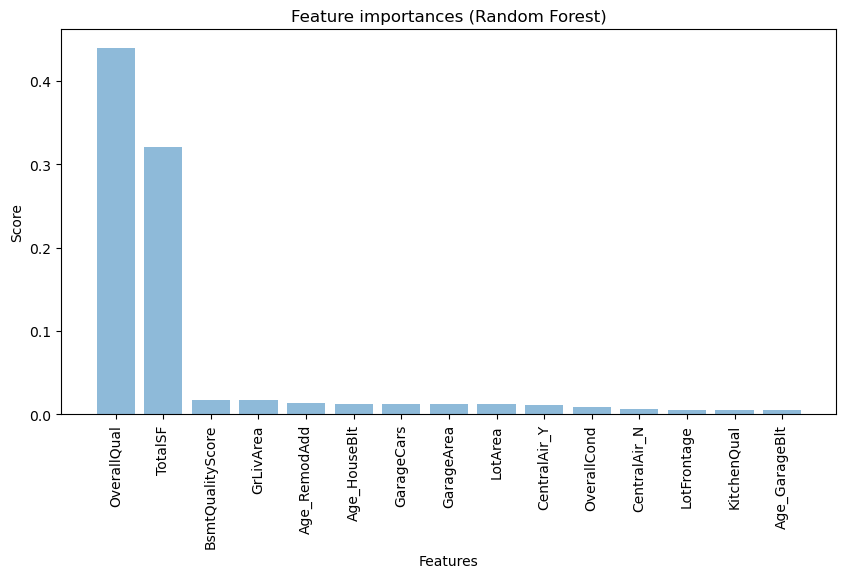

In [ ]:
#get feature importances from the model

# Train RF Regressor
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='squared_error', 
                               random_state=42, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

In [92]:
# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust parameters as needed

# Fit the model
rf.fit(X_train, y_train)

# Predict on training data
y_train_pred = rf.predict(X_train)

# Predict on test set
y_test_pred = rf.predict(X_test)

# Evaluate Model
cv_score = cross_val_score(rf, X_train, y_train, cv=10)
# Compute negative MSE from cross-validation
cv_mse = -cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Compute RMSE
cv_rmse = np.sqrt(cv_mse)

# Compute R² scores from cross-validation
cv_r2 = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')

# Print results
print(f'RF_CV Scores: {cv_scores}')
print(f'RF_Mean CV Score: {cv_scores.mean()}')
print(f'RF_CV Mean Squared Error: {cv_mse.mean():.4f}')
print(f'RF_CV Root Mean Squared Error: {cv_rmse.mean():.4f}')
print(f'RF_CV R² Score: {cv_r2.mean():.4f}')


RF_CV Scores: [0.72476173 0.73407889 0.71794205 0.69886716 0.70981852 0.72101163
 0.73178276 0.72476341 0.62185684 0.73507295]
RF_Mean CV Score: 0.7119955943874704
RF_CV Mean Squared Error: 0.0197
RF_CV Root Mean Squared Error: 0.1392
RF_CV R² Score: 0.8764


### <font color='#7FFFD4'>**6.2.4 XGBoost Model**</font>

In [93]:
# Define model
model = XGBRegressor(enable_categorical=False)  # Explicitly disable categorical support

# Perform manual cross-validation using train_test_split
n_splits =10
rmse_scores = []
r2_scores = []

for i in range(n_splits):
    # Split the data (this is just a simple example, you can use StratifiedKFold for more complex cases)
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred = model.predict(X_val_fold)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    rmse_scores.append(round(rmse,4))
    
    # Calculate R² for this fold
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(round(r2, 4))

# Print results
print("XGB Cross-validation RMSE scores:", rmse_scores)
print("XGB Mean RMSE:", round(np.mean(rmse_scores),4))
print("XGB Cross-validation R² scores:", r2_scores)
print("XGB Mean R²: {:.4f}".format(np.mean(r2_scores)))

XGB Cross-validation RMSE scores: [0.137, 0.1352, 0.1399, 0.1167, 0.1197, 0.1462, 0.1471, 0.1431, 0.1599, 0.1303]
XGB Mean RMSE: 0.1375
XGB Cross-validation R² scores: [0.884, 0.8906, 0.8842, 0.9086, 0.8993, 0.8802, 0.874, 0.8892, 0.8232, 0.8832]
XGB Mean R²: 0.8816


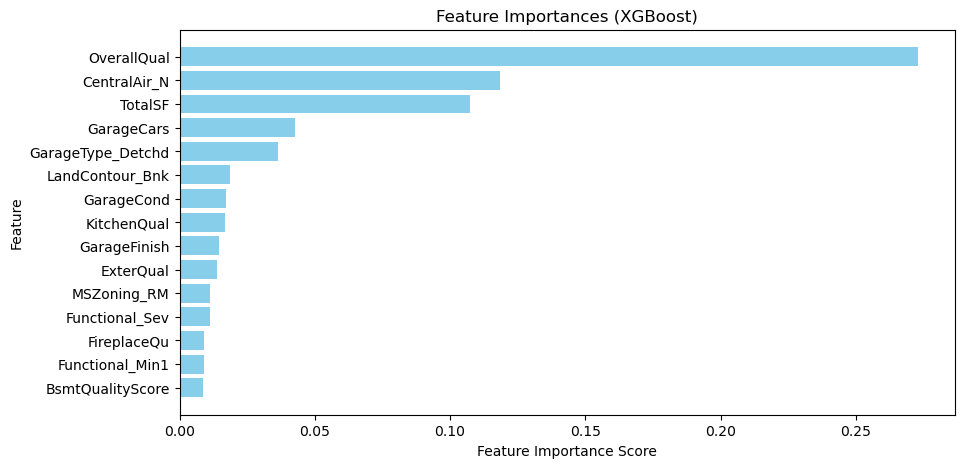

In [94]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns  # Ensure X_train is a DataFrame

# Create DataFrame with feature names and scores
xgb_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
xgb_feature_importances = xgb_feature_importances.sort_values(by='Importance', ascending=False)

# Select top 15 features
top_features = xgb_feature_importances.head(15)

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # Flip to have the highest importance at the top

# Save figure
plt.savefig('feature_importances_XGB.png', bbox_inches='tight')

# Show plot
plt.show()

### <font color='#7FFFD4'>**6.2.5 having models perfomance with CV = 10**</font>

In [95]:
# Define training and test sets
X_train = train_cleaned_feng_encod_scaled
X_test = test_cleaned_feng_encod_scaled
y_train = df[df.train_test == 1].lognorm_SalePrice  # Target variable

# Set up cross-validation strategy
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=42)

# -------------------- LASSO REGRESSION --------------------
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=cv_strategy, random_state=42).fit(X_train, y_train)
lasso_best = Lasso(alpha=lasso_cv.alpha_)
lasso_best.fit(X_train, y_train)

# Evaluate Lasso Model
lasso_mse = -cross_val_score(lasso_best, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = cross_val_score(lasso_best, X_train, y_train, cv=cv_strategy, scoring='r2')

print(f"Lasso Best Alpha: {lasso_cv.alpha_}")
print(f"Lasso CV MSE: {lasso_mse.mean():.4f}")
print(f"Lasso CV RMSE: {lasso_rmse.mean():.4f}")
print(f"Lasso CV R²: {lasso_r2.mean():.4f}")
print("-" * 50)

# -------------------- RIDGE REGRESSION --------------------
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=cv_strategy).fit(X_train, y_train)
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_train, y_train)

# Evaluate Ridge Model
ridge_mse = -cross_val_score(ridge_best, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = cross_val_score(ridge_best, X_train, y_train, cv=cv_strategy, scoring='r2')

print(f"Ridge Best Alpha: {ridge_cv.alpha_}")
print(f"Ridge CV MSE: {ridge_mse.mean():.4f}")
print(f"Ridge CV RMSE: {ridge_rmse.mean():.4f}")
print(f"Ridge CV R²: {ridge_r2.mean():.4f}")
print("-" * 50)

# -------------------- RANDOM FOREST REGRESSION --------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Evaluate Random Forest Model
rf_mse = -cross_val_score(rf, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(rf_mse)
rf_r2 = cross_val_score(rf, X_train, y_train, cv=cv_strategy, scoring='r2')

print(f"RF CV MSE: {rf_mse.mean():.4f}")
print(f"RF CV RMSE: {rf_rmse.mean():.4f}")
print(f"RF CV R²: {rf_r2.mean():.4f}")
print("-" * 50)

# -------------------- XGBOOST REGRESSION --------------------
# Define model
xgb = XGBRegressor(enable_categorical=False)  # Explicitly disable categorical support

# Perform manual cross-validation using train_test_split
n_splits = 10
rmse_scores = []
r2_scores = []

for i in range(n_splits):
    # Split the data (this is just a simple example, you can use StratifiedKFold for more complex cases)
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Train the model
    xgb.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred = xgb.predict(X_val_fold)
    
    # Calculate RMSE for this fold
    mse = (mean_squared_error(y_val_fold, y_pred))
    rmse = np.sqrt(mse)
    rmse_scores.append(round(rmse,4))
    
    # Calculate R² for this fold
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(round(r2, 4))

# Print results

print("XGB CV MSE:", mse)
print("XGB CV RMSE:", round(np.mean(rmse_scores),4))

print("XGB R²: {:.4f}".format(np.mean(r2_scores)))
print("-" * 50)

Lasso Best Alpha: 0.001
Lasso CV MSE: 0.0225
Lasso CV RMSE: 0.1381
Lasso CV R²: 0.8629
--------------------------------------------------
Ridge Best Alpha: 79.06043210907701
Ridge CV MSE: 0.0223
Ridge CV RMSE: 0.1392
Ridge CV R²: 0.8638
--------------------------------------------------
RF CV MSE: 0.0206
RF CV RMSE: 0.1411
RF CV R²: 0.8713
--------------------------------------------------
XGB CV MSE: 0.021014312846122568
XGB CV RMSE: 0.145
XGB R²: 0.8744
--------------------------------------------------


### **Models performance DataFrame**

In [96]:
# Create a dictionary with the results
data = {
    'Model': ['Lasso', 'Ridge', 'Random Forest', 'XGBoost'],
        'CV MSE': [0.0225, 0.0223, 0.0206, 0.0210],
    'CV RMSE': [0.1381, 0.1392, 0.1411, 0.145],
    'CV R²': [0.8629, 0.8638, 0.8713, 0.8744]
}

# Convert dictionary to DataFrame
df_model = pd.DataFrame(data)

# Display the DataFrame
df_model

Model  CV MSE  CV RMSE   CV R²
0          Lasso  0.0225   0.1381  0.8629
1          Ridge  0.0223   0.1392  0.8638
2  Random Forest  0.0206   0.1411  0.8713
3        XGBoost  0.0210   0.1450  0.8744

### **Visualization of moldes performance**

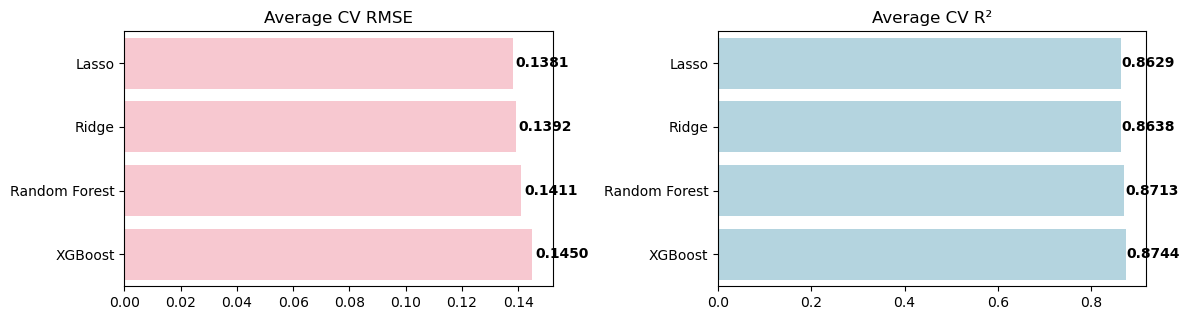

In [97]:
# Plot to visualize evaluation metrics, RMSE and R2 Score
plt.figure(figsize=(12,6))

# Plot for CV RMSE
plt.subplot(2,2,1)
sns.barplot(data=df_model, x='CV RMSE', y='Model', color='pink')

# Add numbers at the end of the bars for CV RMSE
for index, value in enumerate(df_model['CV RMSE']):
    plt.text(value + 0.001, index, f'{value:.4f}', va='center', fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.title('Average CV RMSE', size=12)

# Plot for CV R²
plt.subplot(2,2,2)
sns.barplot(data=df_model, x='CV R²', y='Model', color='lightblue')

# Add numbers at the end of the bars for CV R²
for index, value in enumerate(df_model['CV R²']):
    plt.text(value + 0.001, index, f'{value:.4f}', va='center', fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.title('Average CV R²', size=12)

plt.tight_layout()
plt.show()

### **Insights from comparing evaluation metrics**
- XGBoost performs the best in terms of explanatory power (highest R²), even though it had the highest RMSE. This suggests it captures more variance but may have some overfitting issues.
- Random Forest is a close second, balancing variance explanation and model complexity.
- Lasso and Ridge perform nearly identically, meaning that the relationship between features and SalePrice might be well captured by linear models.

- prioritize predictive accuracy (low RMSE), Lasso seems best.
- care more about variance explanation (high R²), XGBoost is the best.
- want a balance, Ridge or RF might be good options.


## <font color='#FF9FD6'>**7. Feature Importance**</font>

Feature selection helps improve model performance by keeping only the most relevant features. Here are some common techniques to use:
1. Filter Methods (Based on Statistics)
These methods evaluate each feature independently of the model.

  - a. Correlation Analysis
Remove features highly correlated with each other.
Keep features that have a good correlation with the target variable.

  - b. Feature Selection using algorithms

### **7.1. Feature Importance based on Correlation**

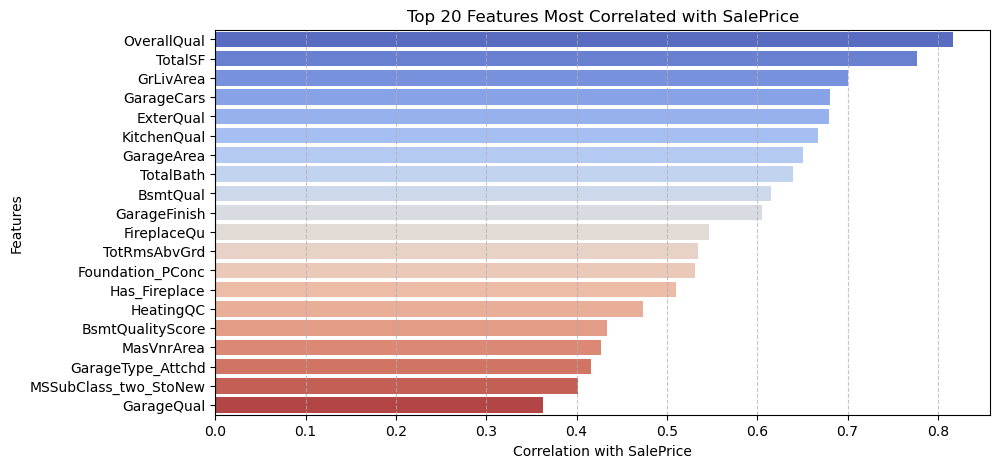

In [59]:
# Because X_train doesn't have SalePrice I Combine X_train and y_train into a single DataFrame
train_with_target = X_train.copy()
train_with_target["SalePrice"] = y_train  # Add target column to X_train

# Compute correlation matrix
corr = train_with_target.corr()

# Get correlation of features with target variable
corr_target = corr["SalePrice"].drop("SalePrice").sort_values(ascending=False)  # Exclude SalePrice itself


# Show top 20 features most correlated with SalePrice
top_features = corr_target.head(20)  # Select top 20 most important features

#print("Top 20 Features Most Correlated with SalePrice:\n")
#print(top_features)

# Plot the top features
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_features.values, 
    y=top_features.index, 
    palette="coolwarm"
)
plt.xlabel("Correlation with SalePrice")
plt.ylabel("Features")
plt.title("Top 20 Features Most Correlated with SalePrice")
plt.axvline(x=0, color="black", linestyle="--", alpha=0.7)  # Adds a reference line at 0
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


### **7.2. Feature Importance based on SelectKBest, f_regression**

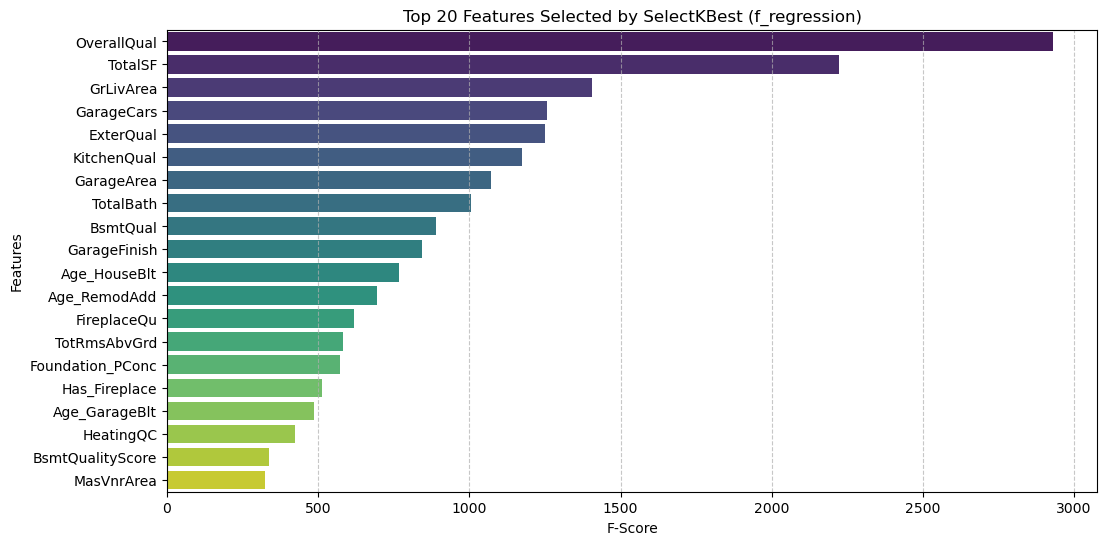

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Select top k features
k = 20  # Adjust based on your needs
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X_train, y_train)

# Get feature names and scores
selected_features_kBest = X_train.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]  # Scores only for selected features

# Store in a DataFrame
feature_importance_kBest = pd.DataFrame({
    "Feature": selected_features_kBest,
    "F-Score": scores
}).sort_values(by="F-Score", ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance_kBest["F-Score"], 
    y=feature_importance_kBest["Feature"], 
    palette="viridis"
)
plt.xlabel("F-Score")
plt.ylabel("Features")
plt.title("Top 20 Features Selected by SelectKBest (f_regression)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


#### **Feature selection methode KBest selected these features;**
 - since I determinded select 15 important features, it chose;
 - ['OverallQual', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF',
 - 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu',
 - 'GarageFinish', 'GarageCars', 'GarageArea', 'Age_HousBlt','Age_RemodAdd']

### **7.3. Lasso Embedded Methods for Feature Importance**
These methods use built-in feature selection from models.

 - a. Lasso Regularization (L1 Penalty)
Lasso regression itself selects features by setting some coefficients to zero.


   Feature by Lasso  Importance
2       OverallQual    0.109228
33          TotalSF    0.073943
27     Age_HouseBlt    0.054069
19       GarageCars    0.047826
12        GrLivArea    0.038807
3       OverallCond    0.036076
34   TotalBsmtFinSF    0.023818
17      FireplaceQu    0.021750
57      MSZoning_RL    0.020187
28     Age_RemodAdd    0.018909
10        HeatingQC    0.017301
30        TotalBath    0.015639
15      KitchenQual    0.015135
1           LotArea    0.013985
16     TotRmsAbvGrd    0.013728
32    TotalBsmtBath    0.009266
9      BsmtExposure    0.008191
18     GarageFinish    0.008020
20       GarageArea    0.007509
7          BsmtQual    0.005047


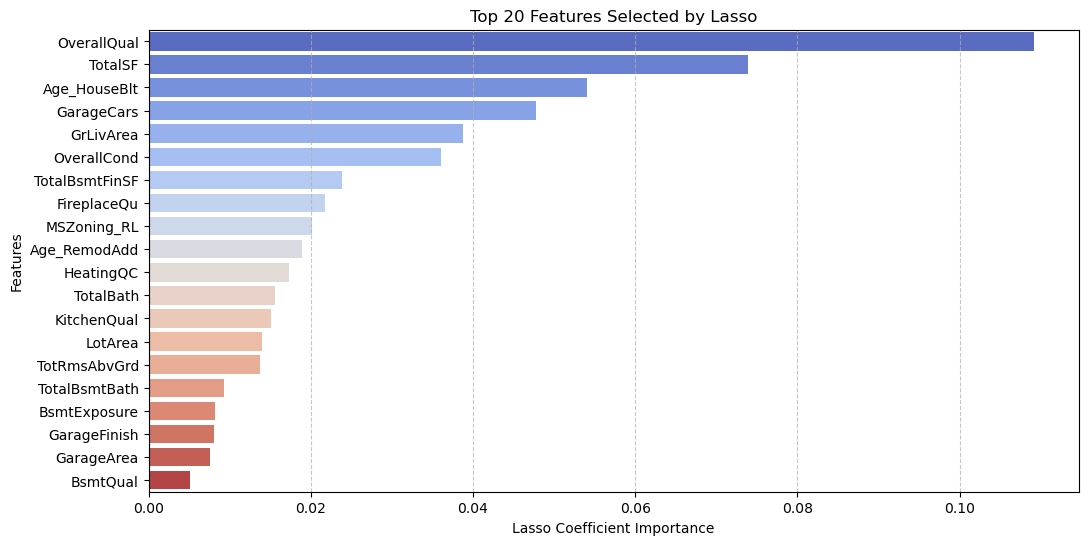

In [56]:
# Apply Lasso method to select important features
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)

# Get feature importance
importance = np.abs(model.coef_)

# Create a DataFrame
feature_importance_lasso_df = pd.DataFrame({
    "Feature by Lasso": X_train.columns,
    "Importance": importance})

# Filter features with non-zero coefficients
selected_features_lasso_df = feature_importance_lasso_df[feature_importance_lasso_df["Importance"] > 0]

# Sort by importance
selected_features_lasso_df = selected_features_lasso_df.sort_values(by="Importance", ascending=False)

# Display the selected features
#print(selected_features_lasso_df)


# Select top 15 most important features
top_features_lasso = selected_features_lasso_df.head(20)

print(top_features_lasso)
# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_features_lasso["Importance"], 
    y=top_features_lasso["Feature by Lasso"], 
    palette="coolwarm"
)
plt.xlabel("Lasso Coefficient Importance")
plt.ylabel("Features")
plt.title("Top 20 Features Selected by Lasso")
plt.axvline(x=0, color="black", linestyle="--", alpha=0.7)  # Reference line at 0
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

### **7.4. RandomForest Methods for Feature Selection**

 - b. Random Forest rank features.

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Get feature importance
importance = model.feature_importances_

# Sort features by importance
feature_importance_RF = pd.DataFrame({"Feature by RF": X_train.columns, "Importance": importance})
feature_importance_RF = feature_importance_RF.sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importance_RF.shape)

(249, 2)


In [62]:
#Try Different Thresholds:
for t in [0.001, 0.005, 0.01, 0.02, 0.05]:
    print(f"Threshold {t}: {sum(feature_importance_RF['Importance'] > t)} features selected")

Threshold 0.001: 42 features selected
Threshold 0.005: 15 features selected
Threshold 0.01: 11 features selected
Threshold 0.02: 2 features selected
Threshold 0.05: 2 features selected


RandomForestRegressor gives 260 features in a row that dosen't have importance order, so I defined a threshold to filter features based on an importance threshold

In [63]:
# Adjust a threshold based on distribution of features on hisplot
threshold = 0.001  # Adjust based on distribution
important_features_RF = feature_importance_RF[feature_importance_RF["Importance"] > threshold]

print(important_features_RF.head(20))

        Feature by RF  Importance
2         OverallQual    0.449050
33            TotalSF    0.309087
12          GrLivArea    0.017119
37   BsmtQualityScore    0.015484
19         GarageCars    0.014108
1             LotArea    0.013216
28       Age_RemodAdd    0.012119
27       Age_HouseBlt    0.011700
20         GarageArea    0.011572
199      CentralAir_Y    0.010822
198      CentralAir_N    0.010307
3         OverallCond    0.009022
0         LotFrontage    0.005934
17        FireplaceQu    0.005133
15        KitchenQual    0.005127
18       GarageFinish    0.004707
54   MSZoning_C (all)    0.004593
31       TotalPorchSF    0.004471
29      Age_GarageBlt    0.004395
30          TotalBath    0.004141


After filtering with threshold greater than 0.001, it keeps only features with an importance score greater than 0.001.



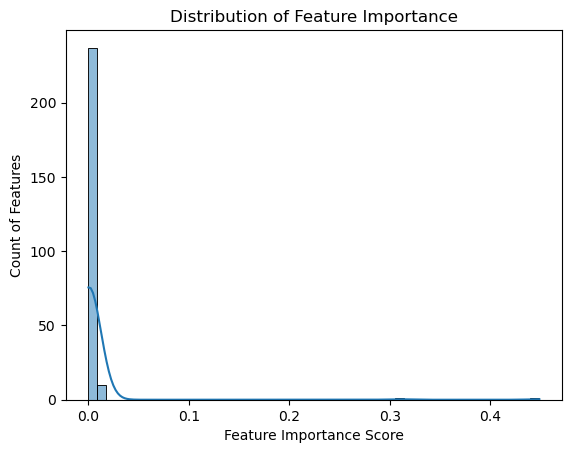

In [64]:
#Check Distribution of Feature Importance:
sns.histplot(feature_importance_RF["Importance"], bins=50, kde=True)
plt.xlabel("Feature Importance Score")
plt.ylabel("Count of Features")
plt.title("Distribution of Feature Importance")
plt.show()


Histogram shows that;
 - Most of the features importance score fell between 0 and 0.1 in which represents less important features or irrelevent features, high scores suggets more important features.
 - the frequency of the important scores for features show the features with less importance have higher frequency and a significant portion of the features are less important.
 - Taller bars indicate a larger number of features near 0 and less than 0.1 of importance.
- So threshold = 0.1 was adujsted to extract the more important features.

### **7.5.Feature Importance by XGBoost model**

        Feature by xgb  Importance
2          OverallQual    0.272807
198       CentralAir_N    0.118626
33             TotalSF    0.107537
19          GarageCars    0.042535
217  GarageType_Detchd    0.036428
68     LandContour_Bnk    0.018575
22          GarageCond    0.017143
15         KitchenQual    0.016919
18        GarageFinish    0.014674
5            ExterQual    0.014020
58         MSZoning_RM    0.011290
210     Functional_Sev    0.011126
17         FireplaceQu    0.009111
207    Functional_Min1    0.009069
37    BsmtQualityScore    0.008719
12           GrLivArea    0.008676
220       PavedDrive_P    0.008087
124      BldgType_1Fam    0.007906
62          Alley_None    0.007861
54    MSZoning_C (all)    0.007514


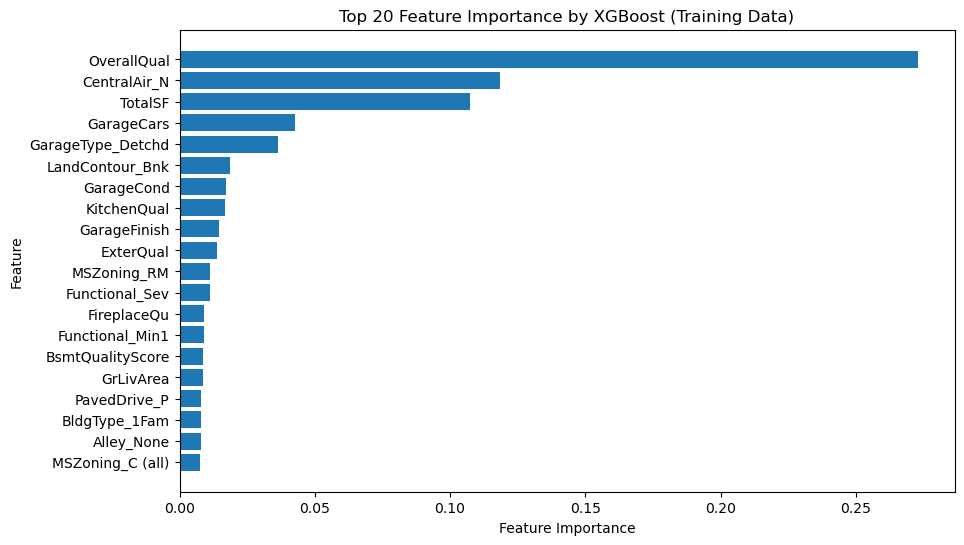

In [65]:

import xgboost as xgb

# Train XGBoost model only on training data
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance for training data only
feature_importance_xgb = xgb_model.feature_importances_

# Create a DataFrame for feature importance
importance_xgb = pd.DataFrame({'Feature by xgb': X_train.columns, 'Importance': feature_importance_xgb})

# Sort by importance
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

print(importance_xgb.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_xgb['Feature by xgb'][:20], importance_xgb['Importance'][:20])  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance by XGBoost (Training Data)")
plt.gca().invert_yaxis()
plt.show()

# Display top 10 important features
##print(importance_xgb.head(20))


### **7.6. SVR model for Feature Importance** 

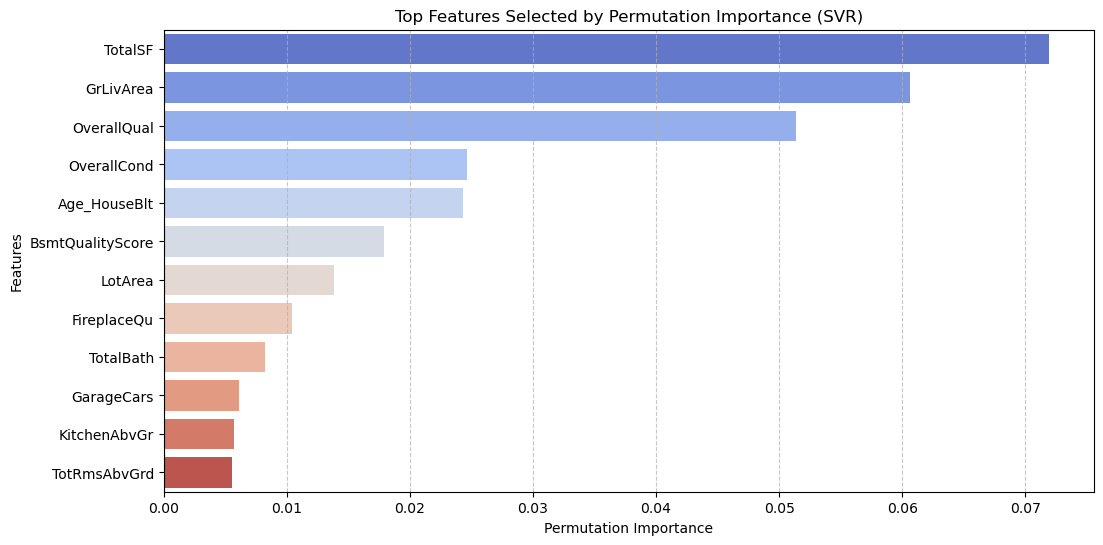

In [89]:

# Support Vector Regressor (RBF) - Using Permutation Importance
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

# Permutation importance for non-linear SVR (RBF kernel)
feature_importance_svr = permutation_importance(svr_rbf, X_train, y_train, n_repeats=10, random_state=0)

# Create DataFrame from the permutation importance result
importance_svr = pd.DataFrame({
    'Feature select_svr': X_train.columns,
    'Importance': feature_importance_svr.importances_mean
})

# Sort the DataFrame by importance in ascending order
importance_svr = importance_svr.sort_values(by='Importance', ascending=False)
filtered_importance = importance_svr[importance_svr['Importance']>=0.005]
# Display the DataFrame
#print(filtered_importance)

# Plot the feature importance based on permutation importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=filtered_importance['Importance'], 
    y=filtered_importance['Feature select_svr'], 
    palette="coolwarm"
)
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Top Features Selected by Permutation Importance (SVR)")
plt.axvline(x=0, color="black", linestyle="--", alpha=0.7)  # Adds a reference line at 0
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


### **7.7. Feature Enginnering with LightGBM**

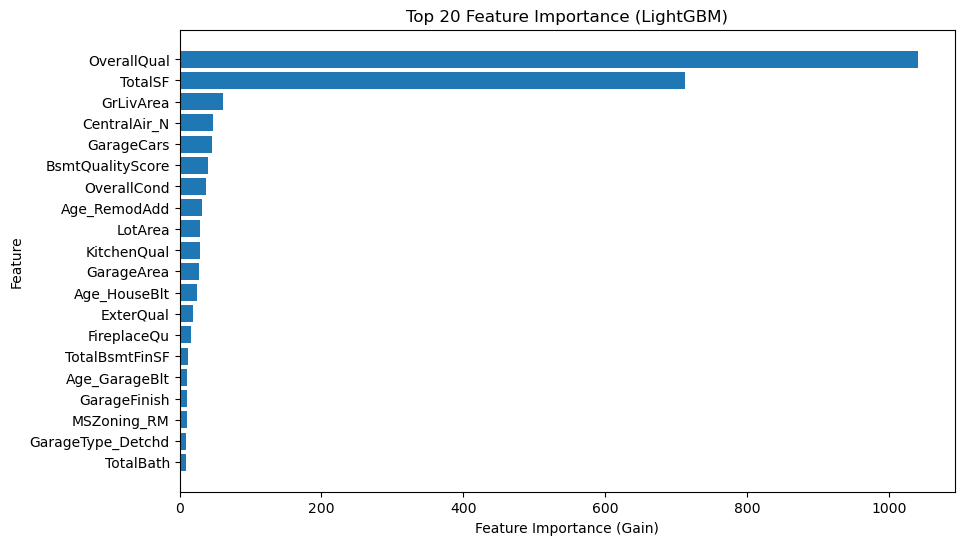

In [ ]:
import lightgbm as lgb

# Create LightGBM dataset
train_data_lgb = lgb.Dataset(X_train, label=y_train)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Train LightGBM model
lgb_model = lgb.train(params, train_data_lgb, num_boost_round=200)

# Get feature importance (using 'gain' for better interpretability)
feature_importance = lgb_model.feature_importance(importance_type='gain')

# Create DataFrame for feature importance
importance_lgb = pd.DataFrame({'Feature by lgb': X_train.columns, 'Importance': feature_importance})
importance_lgb = importance_lgb.sort_values(by='Importance', ascending=False)

# Plot feature importance (Top 20 features)
plt.figure(figsize=(10, 6))
plt.barh(importance_lgb['Feature by lgb'][:20], importance_lgb['Importance'][:20])
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance (LightGBM)")
plt.gca().invert_yaxis()
plt.show()

# Display top 20 important features
##print(importance_lgb.head(20))


The top 20 most important featurs for predict house price are;
- OverallQuall, TotalSF, GrLivArea,  GarageCars, Age_HouseBlt, TotalBsmtSF, TotRmsAbvGrd, OverallCond, ExterQual, KitchenQuall, MSZoning, CentralAir_N, Age_RemodAdd, GarageArea, GarageType, BsmtQualScore 


## <font color=#FF9FD6>**8. Voting Regressors- Final Submission**</font>
Combining predictions from different applied machine learning models, It gives an average prediction result based on the prediction of all the submodels. 

In [98]:
# Define individual regressors
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
ridge_best = Ridge(alpha=best_alpha)
lasso_best = Lasso(alpha=best_alpha)

# Create a Voting Regressor
voting_reg = VotingRegressor(estimators=[('rf', rf), ('gb', gb), ('ridge', ridge_best), ('lasso', lasso_best)])

# Fit the model
voting_reg.fit(X_train, y_train)

# Predict on test data
y_pred = voting_reg.predict(X_test)
y_pred

Id_train = train['Id']
test_ID = test['Id']
submission_avg = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': np.exp(y_pred)})

# Show a preview of the DataFrame
print(submission_avg.head(20))

# Save to CSV
submission_avg.to_csv('Average_models2_Price.csv', index=False)

      Id      SalePrice
0   1461  127635.553051
1   1462  159046.908597
2   1463  174790.695518
3   1464  184154.546678
4   1465  184181.514361
5   1466  172644.550858
6   1467  173581.948149
7   1468  169986.150068
8   1469  183009.031017
9   1470  132921.754541
10  1471  190953.338475
11  1472  110271.633824
12  1473  111221.127605
13  1474  153942.535073
14  1475  137228.122491
15  1476  292909.810849
16  1477  221498.737138
17  1478  251031.482278
18  1479  246196.267264
19  1480  366348.337590


## <font color='#FF9FD6'>**9 Conclusion**</font>
- Model Performane:
  - Lasso Regression is the best choice for predictive accuracy (low RMSE) while also performing automatic feature selection.
  - XGBoost explains more variance but at the cost of higher error (higher RMSE), possibly due to overfitting.
  - Random Forest and Ridge Regression perform well but are slightly less optimal than Lasso.

- Top Features for Predicting House Price:
   - The 20 most important features influencing house prices in this model are:
     - OverallQual, TotalSF, GrLivArea, GarageCars, Age_HouseBlt, TotalBsmtSF, TotRmsAbvGrd, OverallCond, ExterQual, KitchenQual, MSZoning, CentralAir_N, Age_RemodAdd, GarageArea, GarageType, BsmtQualScore
- These features highlight the significance of house quality, total living space, basement area, garage capacity, and renovations in determining property prices.     


## <font color='#FF9FD6'>**10 Recommendation**</font>
- Based on this analysis, here is the tips for home buyers:
  * Prioritize quality over just size—a well-built home with high-quality materials may be a better investment.
  * Consider future renovations—homes with good bones but outdated interiors can be upgraded for value appreciation.
  * Check for essential features like garage space, finished basements, and modern kitchens, as they have a direct impact on pricing.
  * Evaluate the neighborhood & zoning regulations to understand long-term investment potential.
  * Older homes may be cheaper, but recent renovations can save future costs.